# Segregação do In em poços quânticos de In$_x$Ga$_{1-x}$As sobre GaAs

## Bibliotecas utilizadas

In [35]:
import numpy as np
import scipy.constants as cte
from scipy.signal import gaussian
from scipy.special import legendre
from scipy.sparse import diags
from scipy.linalg import inv
from scipy.integrate import simps
from scipy.optimize import newton
from scipy.interpolate import interp1d

## Configurações gráficas

In [36]:
import locale
locale.setlocale(locale.LC_NUMERIC, "pt_BR.UTF-8")

import matplotlib.style
import matplotlib as mpl
mpl.style.use('classic')

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
plt.style.use('mestrado')

## Constantes e definições

In [37]:
# constantes
au_l   = cte.value('atomic unit of length')
au_t   = cte.value('atomic unit of time')
au_e   = cte.value('atomic unit of energy')
ev     = cte.value('electron volt')
au2ang = au_l / 1e-10
au2ev  = au_e / ev

## Parâmetros macro

In [38]:
N      = 2048
z_ang  = np.linspace(-250.0, 250.0, N) # Angstrom
z_au   = z_ang / au2ang

## Funções para obtenção de níveis de energia

In [39]:
def fi(v, i):
    """
    short for flex_index, find the index i in array v
    i might be float, so that for i = 1.5, returns
    (v[2]+v[1])/2
    """
    if i < 0.0:
        return v[0]
    elif i >= len(v) - 1:
        return v[-1]
    
    try:
        i_up   = int(np.ceil(i))
        i_down = int(np.floor(i))
        return (v[i_up]+v[i_down])/2.0
    except:
        return 0.0
    
def eigenvalue(z, V, psi, m):
    """
    calculate eigenvalue like E=<Psi|H|Psi>/<Psi|Psi>
    """
    dz    = z[1]-z[0]
    dz2   = dz**2
    h_psi = np.zeros(N, dtype=np.complex_)
    
    for i in range(N):
        h_psi[i] = ((0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i])*psi[i]
        
        if i > 0:
            h_psi[i] += -(0.5/dz2)*(psi[i-1]/fi(m,i-0.5))
            
        if i < N-1:
            h_psi[i] += -(0.5/dz2)*(psi[i+1]/fi(m,i+0.5))
            
    psi_h_psi = simps(psi.conj()*h_psi, z)
    return (psi_h_psi / simps(psi.conj()*psi, z)).real
    
    
def fundamental(z, V, m):
    """
    finds the fundamental state under potential V for coordinate
    space z and effective mass m
    everything is expected to be in atomic units
    """
    
    dz  = z[1]-z[0]
    dz2 = dz**2
    
    # kick start function
    psi       = np.array(gaussian(N, std=int(N/100)), dtype=np.complex_)
    psi      /= np.sqrt(simps(psi.conj()*psi,z))
    
    sub_diag  = np.zeros(N-1, dtype=np.complex_)
    main_diag = np.zeros(N  , dtype=np.complex_)

    for i in range(N):
        try:
            main_diag[i] = (0.5/dz2)*(1.0/fi(m,i+0.5)+1.0/fi(m,i-0.5))+V[i]
        except:
            main_diag[i] = 0.0
        
        if i < N-1:
            sub_diag[i] = -(0.5/dz2)*(1.0/fi(m,i+0.5))
    
    diagonals = [main_diag, sub_diag, sub_diag]
    A         = diags(diagonals, [0, -1, 1]).toarray()
    invA      = inv(A)
    
    counter   = 0
    precision = 1.0
    lastval   = 100.0
    eigenval  = 0.0
    
    while True:
        counter  += 1
        psi       = invA.dot(psi)
        #psi      /= np.sqrt(simps(psi.conj()*psi, z))
        eigenval  = eigenvalue(z, V, psi, m)
        precision = np.abs(1-eigenval/lastval)
        lastval   = eigenval
        
        if precision < 1e-8:
            break
        
    
    return {
        'eigenvalue': eigenval,
        'eigenvector': psi
    }

## Aplicação ao nível fundamental de um poço de $Al_x Ga_{1-x} As/GaAs$

Vamos aplicar as funções acima à um poço de $Al_x Ga_{1-x} As/GaAs$ com $x=0.0$ dentro do poço e $x=0.2$ nas barreiras e largura de $80$ Å. A fórmula para o GAP a $0 K$ é dada por:

$$E_g (x) = 1.519+1.447x -0.15 x^2 \,\,\,\, (eV)$$

No caso:

$$E_g(0.0) = 1,519 \,\,\,\, (eV)$$
$$E_g(0.2) = 1,8024 \,\,\,\, (eV)$$

O GAP do Vamos escolher o *band offset* como $70\%$ da diferença de GAP para a banda de condução e $30\%$ para a banda de valência. Como na figura à seguir:

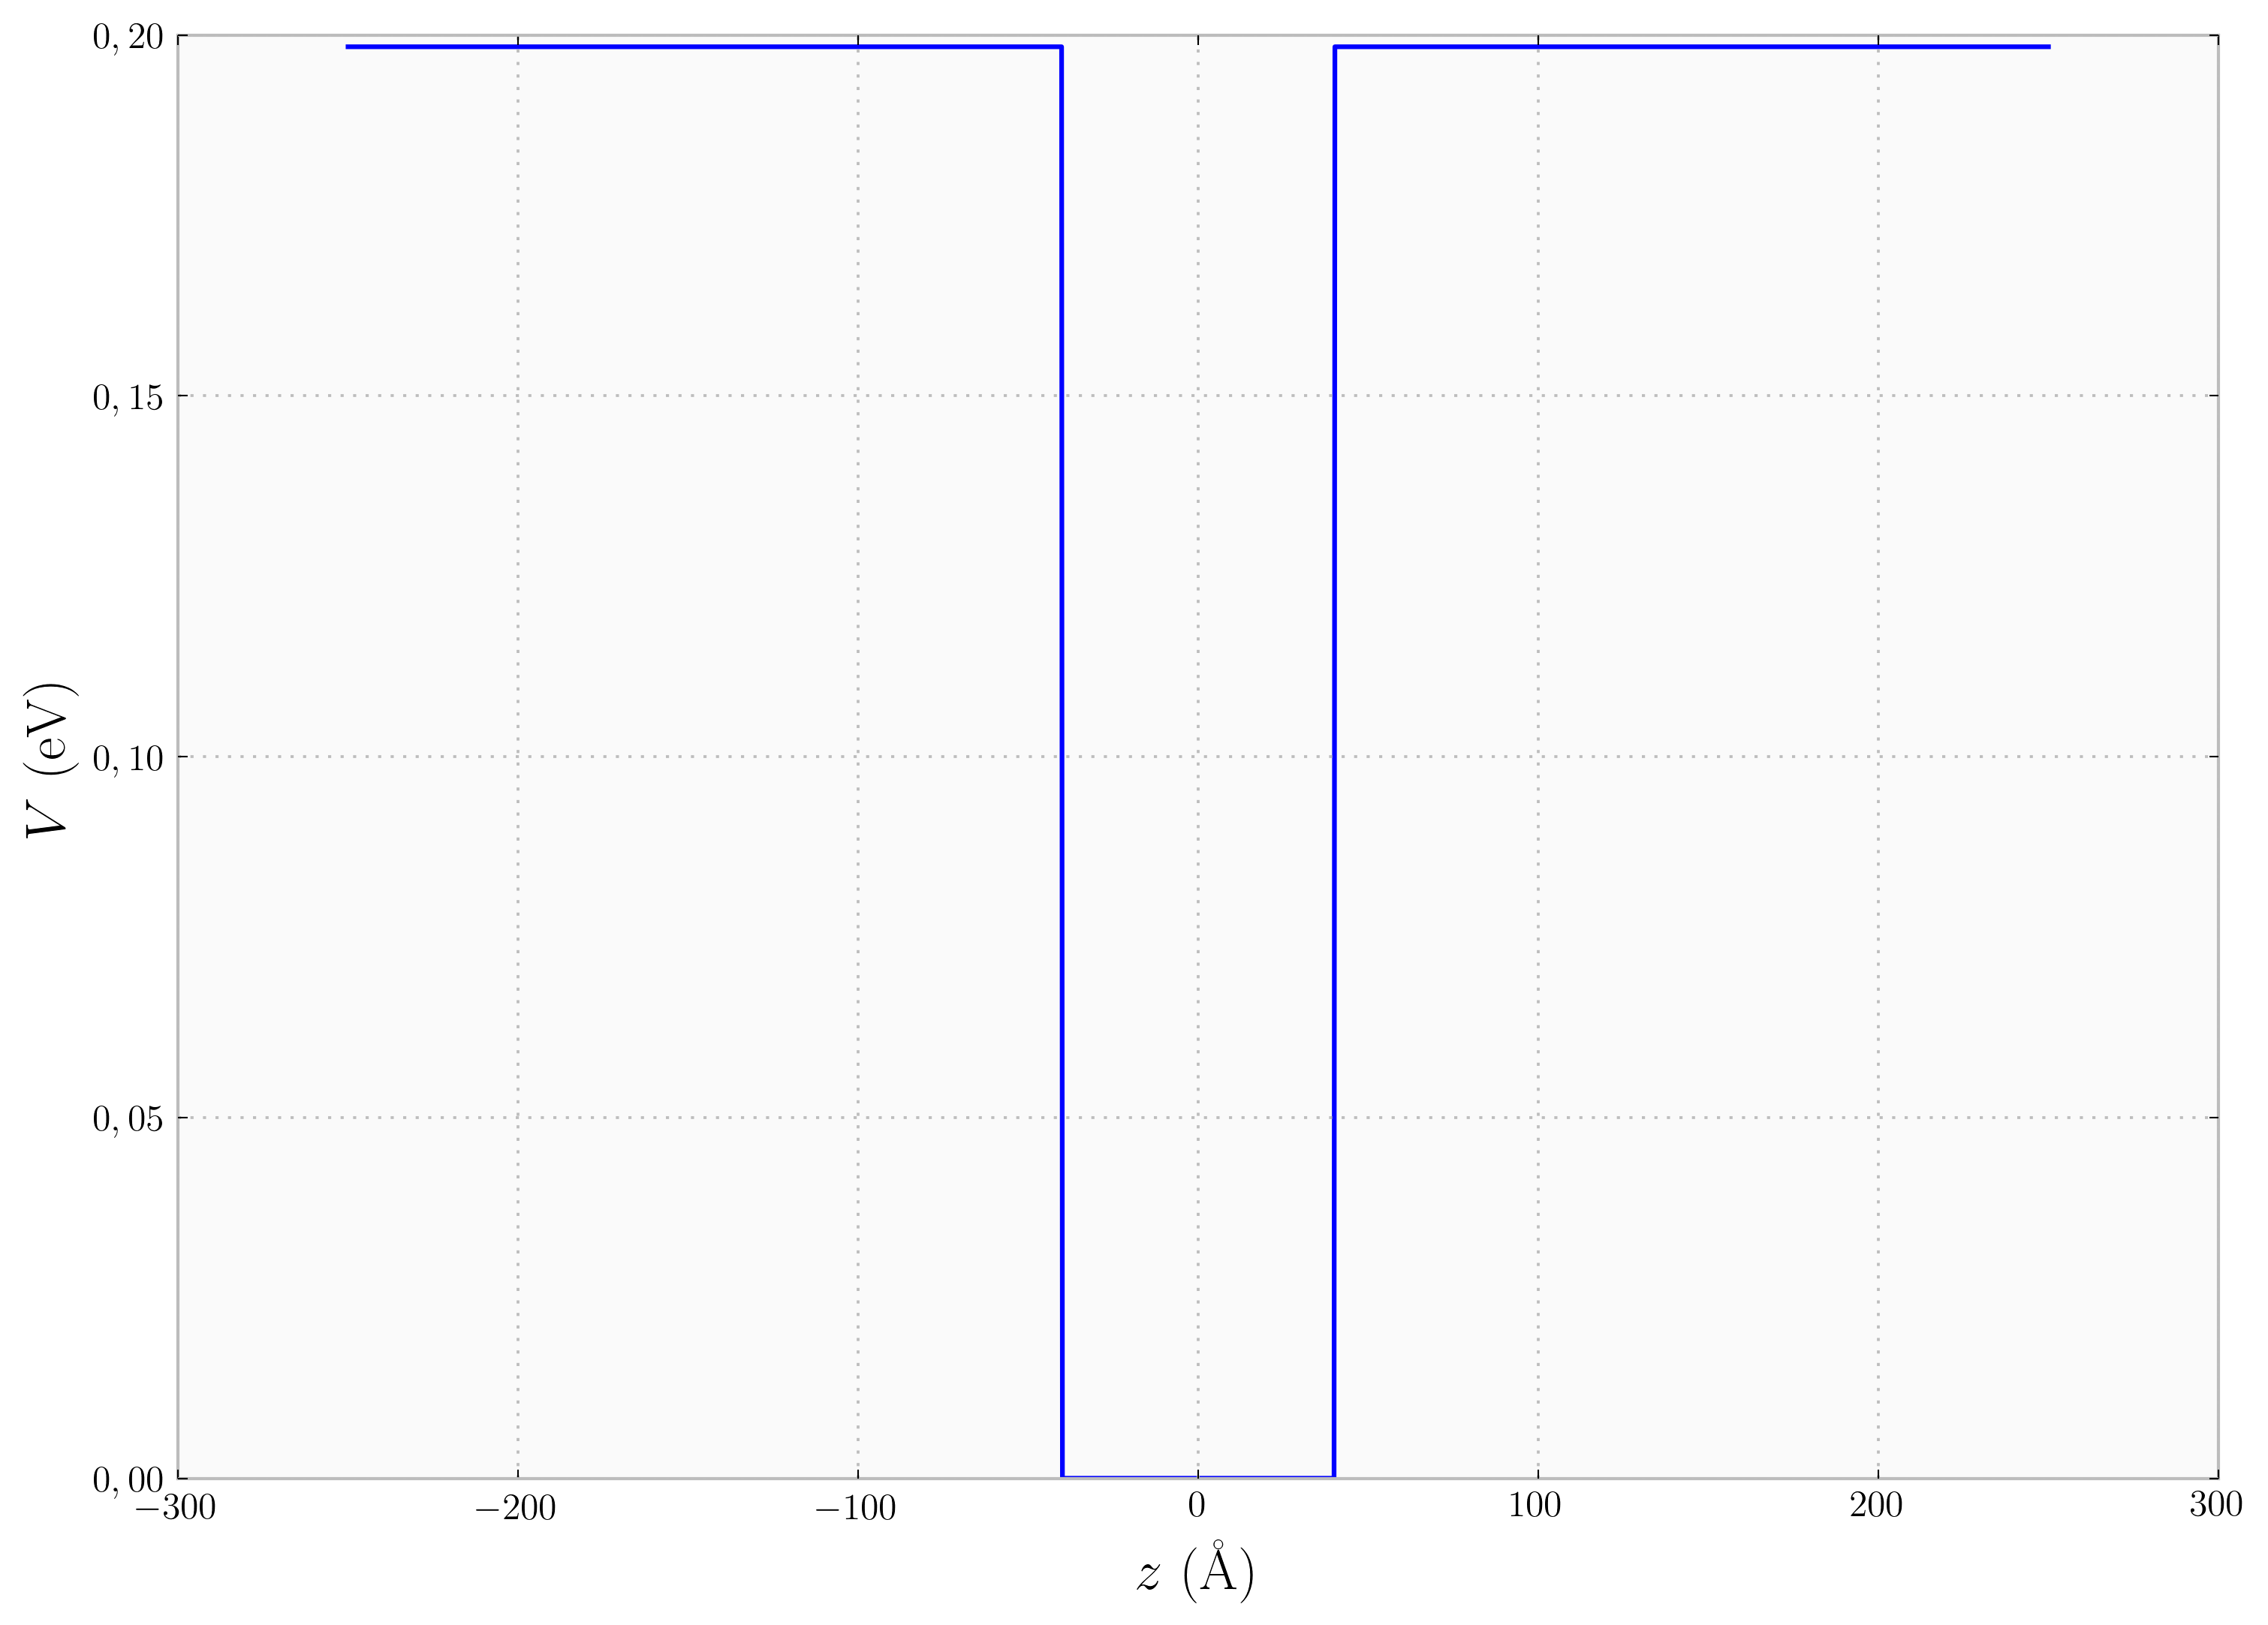

In [40]:
g_algaas = lambda x: 1.519+1.447*x-0.15*x**2 # GAP
m_algaas = lambda x: 0.067+0.083*x # effective mass
x_b      = 0.2 # barrier
x_w      = 0.0 # well
wl       = 80.0 # Angstrom
VBO      = 0.3
CBO      = 0.7
v_shape  = lambda z: g_algaas(x_b) if np.abs(z) > wl/2 else g_algaas(x_w)
#m_shape  = lambda z: m_algaas(x_b) if np.abs(z) > wl/2 else m_algaas(x_w)
m_shape  = lambda z: m_algaas(x_w)
V        = np.vectorize(v_shape)(z_ang)*CBO
V       -= np.min(V)
meff     = np.vectorize(m_shape)(z_ang)

fig, ax = plt.subplots()
ax.set_xlabel(r'$z$ (\AA)')
ax.set_ylabel(r'$V$ (eV)$')
ax.plot(z_ang, V)
ax.grid(True)
plt.show()

Nosso potencial está em eV, vamos converter ele para unidades atômicas, fazendo o mesmo para o vetor de coordenadas.

In [41]:
V_au = V / au2ev
z_au = z_ang / au2ang

Vamos agora calcular o primeiro nível de energia

In [42]:
res = fundamental(z_au, V_au, meff)
value  = res['eigenvalue'] * au2ev # in eV

# change from au to ang
vector  = res['eigenvector']
vector /= np.sqrt(simps(vector.conj()*vector, z_ang))

print(r"E0 = %.8f eV" % value)

E0 = 0.04220813 eV


A solução analítica para esse potencial pode ser obtida a para

$$
\tan \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = \sqrt{\frac{(V_b-E_n)}{E_n}}
$$

$$
\cot \left( \sqrt{\frac{a^2 m_e^* E_n}{2 \hbar^2}} \right) = -\sqrt{\frac{(V_b-E_n)}{E_n}}
$$

Onde $a=80$ Å e $V_b=0.7 \times (E_g(0.2)-E_g(0.0))$. Para a solução analítica, adotamos $m_e^*$ como sendo a massa efetiva do elétron dentro do poço, ou seja, a massa efetiva do $GaAs$ ($0.067$).

In [43]:
import warnings
warnings.filterwarnings('error')

m_eff = 0.067
wl_au = wl / au2ang
vb_au = np.ptp(V_au)

trans_tan = lambda e: np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) - np.sqrt(vb_au/e - 1.0)

trans_tan_der = lambda e: 1.0 / np.cos(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) + vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

trans_cot = lambda e: 1.0 / np.tan(
        np.sqrt(2*m_eff*e)*wl_au/2
    ) + np.sqrt(vb_au/e - 1.0)

trans_cot_der = lambda e: -1.0 / np.sin(
        np.sqrt(2*m_eff*e)*wl_au/2
    )**2 * (
        m_eff * wl_au / (2 * np.sqrt(2*m_eff*e))
    ) - vb_au / (2.0 * e**2 * np.sqrt(vb_au/e - 1.0))

t_functions = [
    (trans_tan,trans_tan_der),
    (trans_cot, trans_cot_der)
]

# kickstart energies values
energies = np.linspace(-0.1*vb_au, 1.1*vb_au, 10000)
eigenvalues = []
for f,fp in t_functions:
    for e0 in energies:
        try:
            root = newton(f, x0=e0, fprime=fp)
            if root > 0:
                eigenvalues.append(root * au2ev)
        except:
            pass

eigenvalues = np.array(list(sorted(set(eigenvalues))))

# eigenvalues at this point is a huge list with almost
# 2000 elements, many of them almost the same, duo to 
# kickstart values leading to the same eigenvalue 
# the code bellow identifies the proper ranges and get the
# average of each, actually, the difference is only
# the numerical error, which is about 1e-11 eV for an 
# eigenvalue of order 0.01 eV
offset = [0]
for i in range(1, eigenvalues.size):
    if np.abs(eigenvalues[i] / \
            np.average(eigenvalues[offset[-1]:i])-1.0) > 0.01:
        offset.append(i)
offset.append(len(eigenvalues))
eigenvalues = [np.average(eigenvalues[offset[i]:offset[i+1]]) \
    for i in range(len(offset)-1)]

for i, eigen in enumerate(eigenvalues):
    print("E%d = %.8f eV" % (i, eigen))

E0 = 0.04229259 eV
E1 = 0.15258258 eV


Vemos que o primeiro autovalor analítico está em grande acordo com o valor obtido numericamente.

$$
\Delta \approx 0.04229259 - 0.04220813 = 0.00008446 eV \approx 80 \mu eV 
$$

## PL do In$_{0.14}$Ga$_{0.86}$As sobre GaAs

Vamos agora passo a passo tentar reproduzir os valores obtidos experimentalmente.

Amostra crescida a 475 °C e PL medida a 77 K:

> ML=10, PL= 1.43922 eV

> ML=15, PL= 1.40796 ev

> ML=21, PL= 1.38241 eV

> ML=28, PL= 1.36353 eV

Amostra crescida a 525 °C e PL medida a 77 K:

> ML=10, PL= 1.45337 eV

> ML=15, PL= 1.42287 ev

> ML=21, PL= 1.39625 eV

> ML=28, PL= 1.37674 ev

Onde ML é abreviação de Monolayers (metade do parametro de rede).

Apenas para fins de comparação gradual:

In [44]:
samples_old = {
    'ml': [10, 15, 21, 28],
    475: [1.43681, 1.40565, 1.38018, 1.36112],
    525: [1.45091, 1.42051, 1.39425, 1.37454]
}

samples = {
    'ml': [10, 15, 21, 28],
    475: [1.43922, 1.40796, 1.38241, 1.36353],
    525: [1.45337, 1.42287, 1.39625, 1.37674]
}

def sample_skeleton():
    return {
        'ml': [10, 15, 21, 28],
        475: [0, 0, 0, 0],
        525: [0, 0, 0, 0]
    }

R_T = {
    525: 0.867,
    475: 0.778
}

x0 = 0.14 # indended indium concentration

pl_numeric = {}

Vamos começar com um poço de $InGaAs$ simples. Sendo GAP do $In_x Ga_{1-x} As$ a $2$ K dado por:

$$
E_g (x) = 1.522-1.1 x +0.4 x^2 \,\,\,\, eV
$$

Além disso, as massas efetivas do elétron e do buraco pesado na direção de crescimento (respectivamente) são dadas por:

$$
1/ m_e (x) = x/0.023 + (1-x)/0.067   \\
1/ m_{hh_z} (x) = x/0.263 + (1-x)/0.333
$$

Por fim, o parâmetro de rede é dado por:

$$
a_0 (x) = 6.0584 x + 5.6533 (1-x) \,\,\,\, Å
$$

In [45]:
eg_2 = lambda x: 1.522-1.1*x+0.4*x**2
me   = lambda x: 1.0/(x/0.023+(1-x)/0.067)
mhh  = lambda x: 1.0/(x/0.263+(1-x)/0.333)
a0   = lambda x: 6.0584*x + 5.6533*(1-x)

## Ajustando *GAP* para $77$ K

Até agora utilizamos o *GAP* do material a $0$ K, vamos utilizar esta expressão à seguir que vale para o $In_{1-x} Ga_x As$:

$$
E_g (x,T) = 0.42 + 0.625 x - \left(\frac{5.8}{T+300} - \frac{4.9}{T+271} \right) 10^{-4} T^2 x - 4.19 \, 10^{-4} \frac{T^2}{T+271} + 0.475 x^2 \,\,\,\, (eV)
$$

apenas para ter uma noção do comportamento dessa expressão, mostramos a seguir para $x=0.10$, $x=0.15$ e $x=0.20$.

**Já vamos trocar tudo que for $x$ por $1-x$ e vice-versa, pois a fórmula acima vale para $In_{1-x} Ga_x As$.**

[]

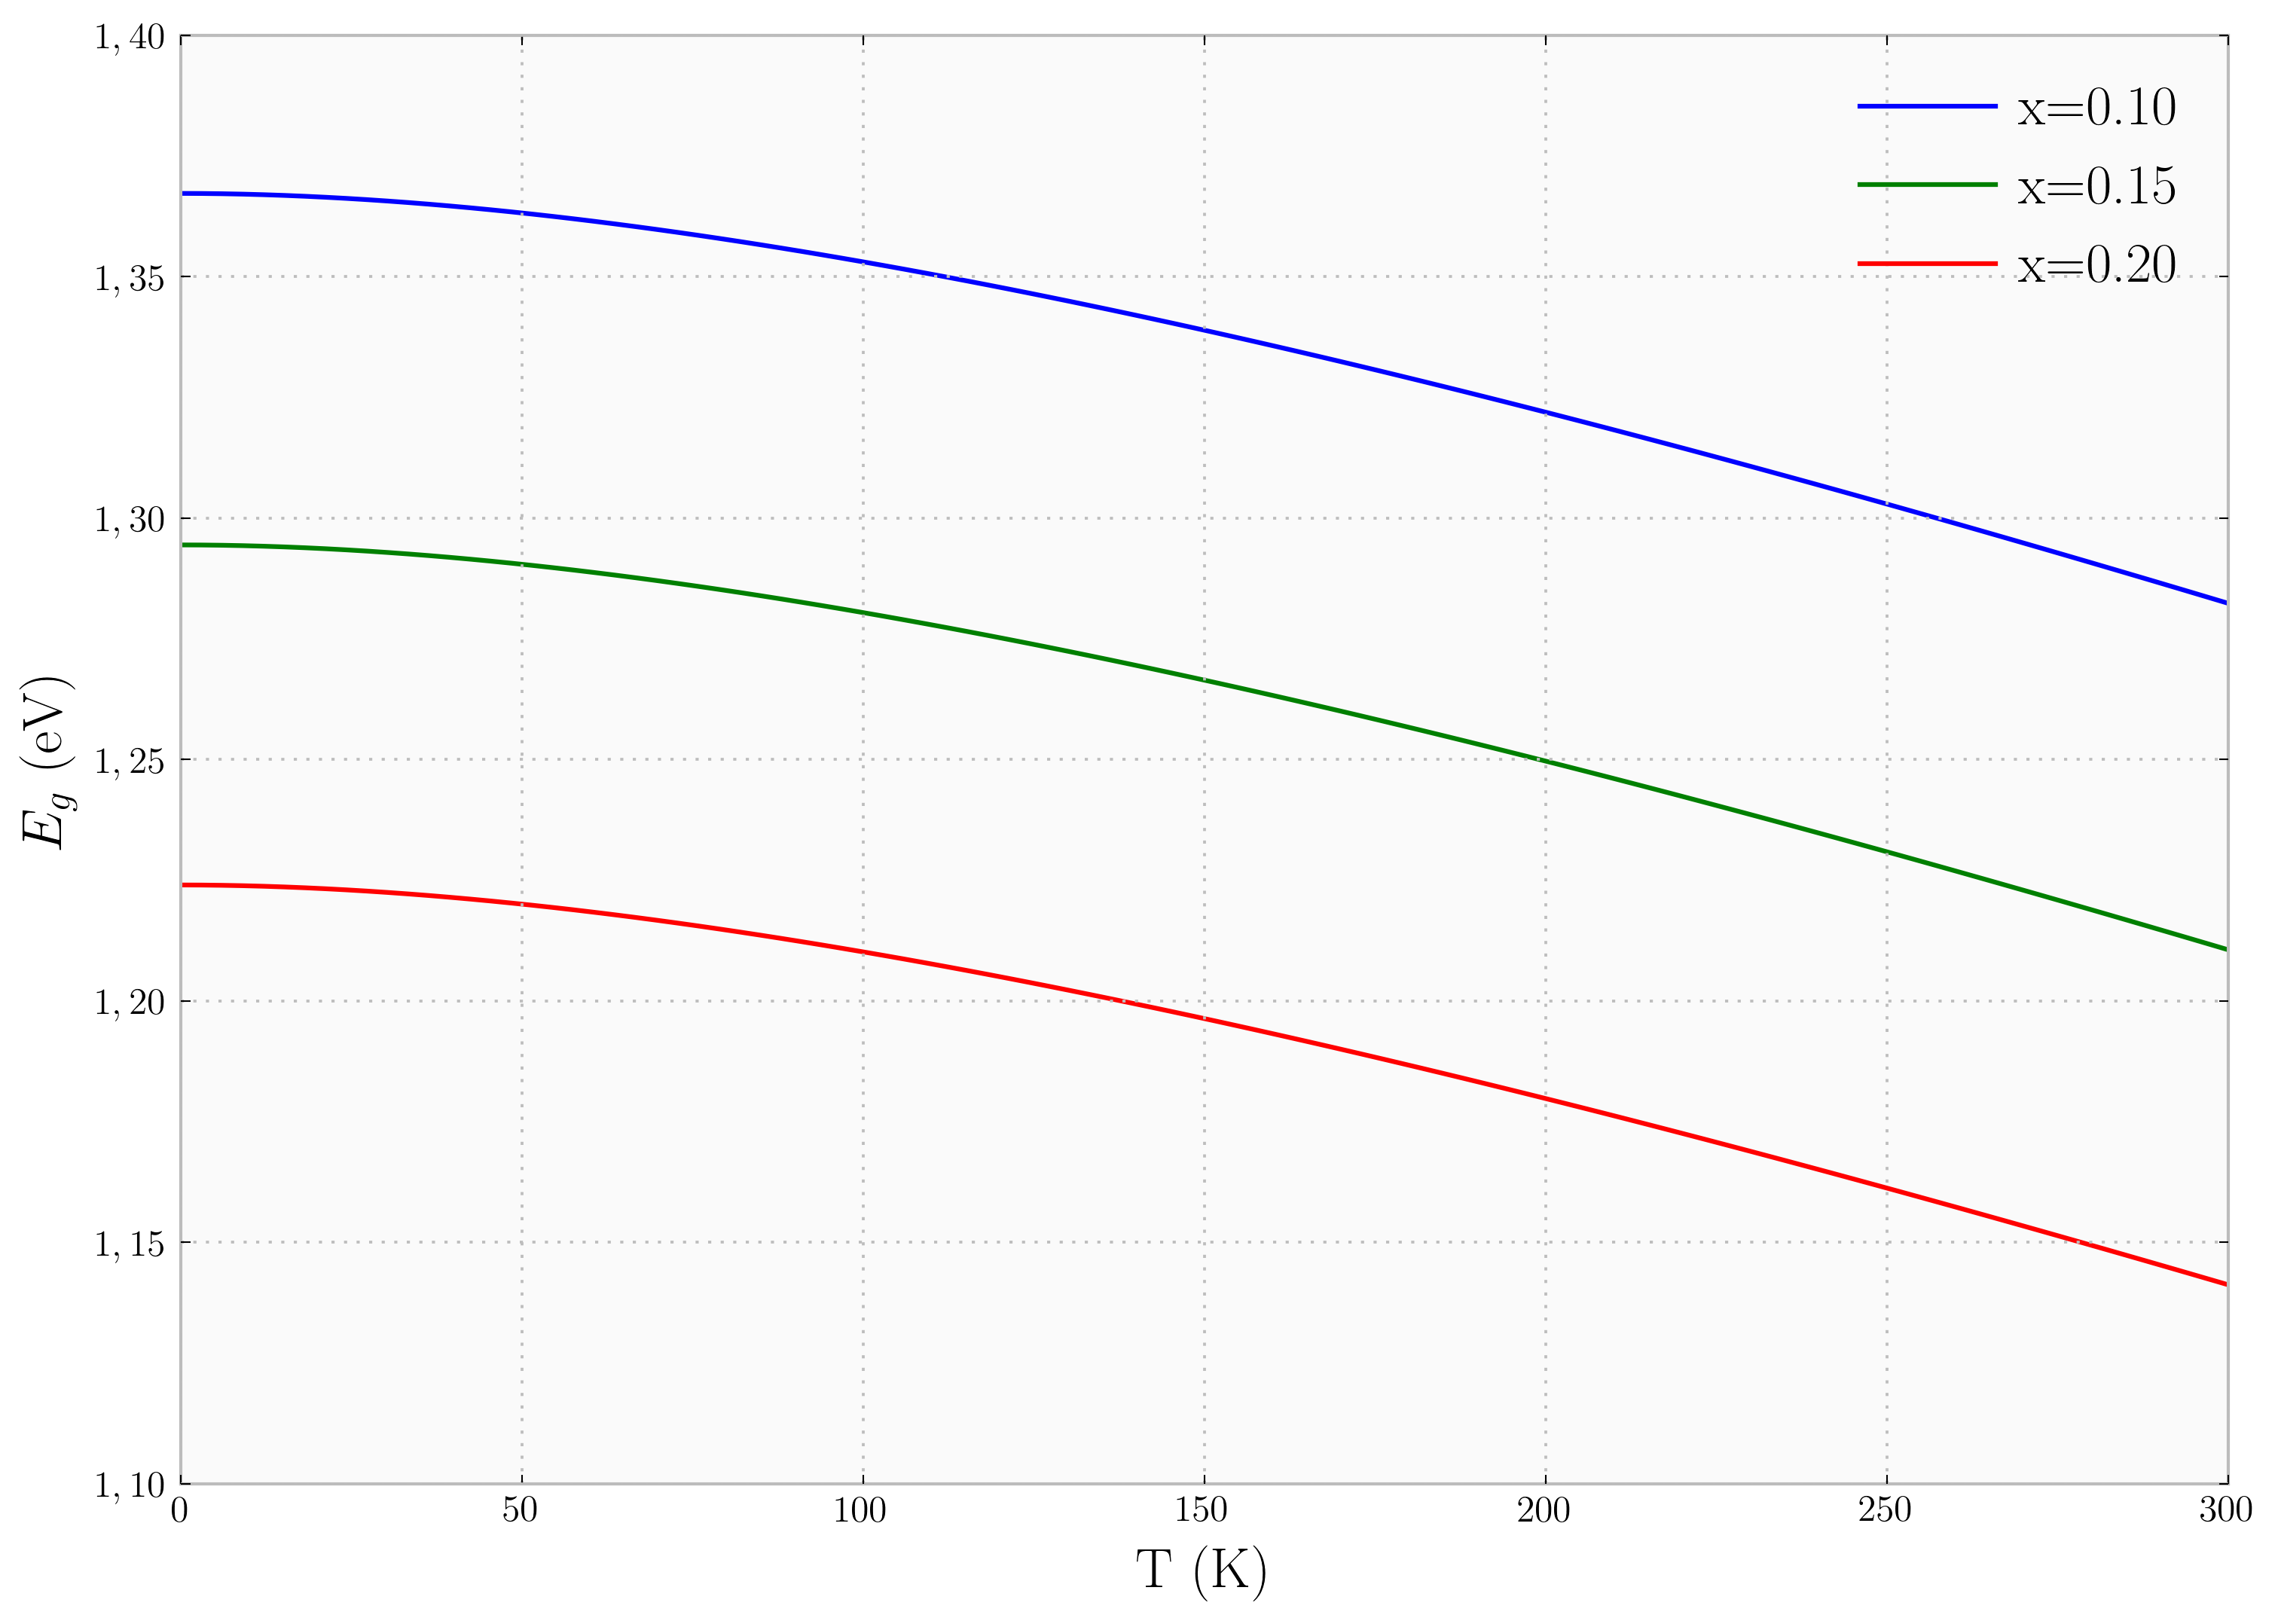

In [46]:
eg_xt_ingaas = lambda x,T: 0.42+0.625*(1-x)-(5.8/(T+300)-4.19/(T+271))*1e-4*(T**2)*(1-x) - 4.19e-4 * ((T**2)/(T+271))+0.475*(1-x)**2

T_range = np.linspace(0,300,100)
eg_10_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.10], T_range)
eg_15_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.15], T_range)
eg_20_t_ingaas = np.vectorize(eg_xt_ingaas)(100*[0.20], T_range)

fig, ax = plt.subplots()

x10, = ax.plot(T_range, eg_10_t_ingaas)
x15, = ax.plot(T_range, eg_15_t_ingaas)
x20, = ax.plot(T_range, eg_20_t_ingaas)
ax.grid(True)
ax.set_xlabel('T (K)')
ax.set_ylabel('$E_g$ (eV)')

plt.legend([x10, x15, x20], ['x=0.10','x=0.15','x=0.20'], loc='best')
plt.plot()

In [47]:
# saving values for future comparison
pl_numeric['temp_only'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = [x0] * ml #x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['temp_only'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4534, PL_num = 1.3751
T = 475 C, R = 0.7780, ML = 10, PL = 1.4392, PL_num = 1.3751
T = 525 C, R = 0.8670, ML = 15, PL = 1.4229, PL_num = 1.3468
T = 475 C, R = 0.7780, ML = 15, PL = 1.4080, PL_num = 1.3468
T = 525 C, R = 0.8670, ML = 21, PL = 1.3962, PL_num = 1.3298
T = 475 C, R = 0.7780, ML = 21, PL = 1.3824, PL_num = 1.3298
T = 525 C, R = 0.8670, ML = 28, PL = 1.3767, PL_num = 1.3194
T = 475 C, R = 0.7780, ML = 28, PL = 1.3635, PL_num = 1.3194


Vemos que este ajuste abaixou demais os níveis:

[]

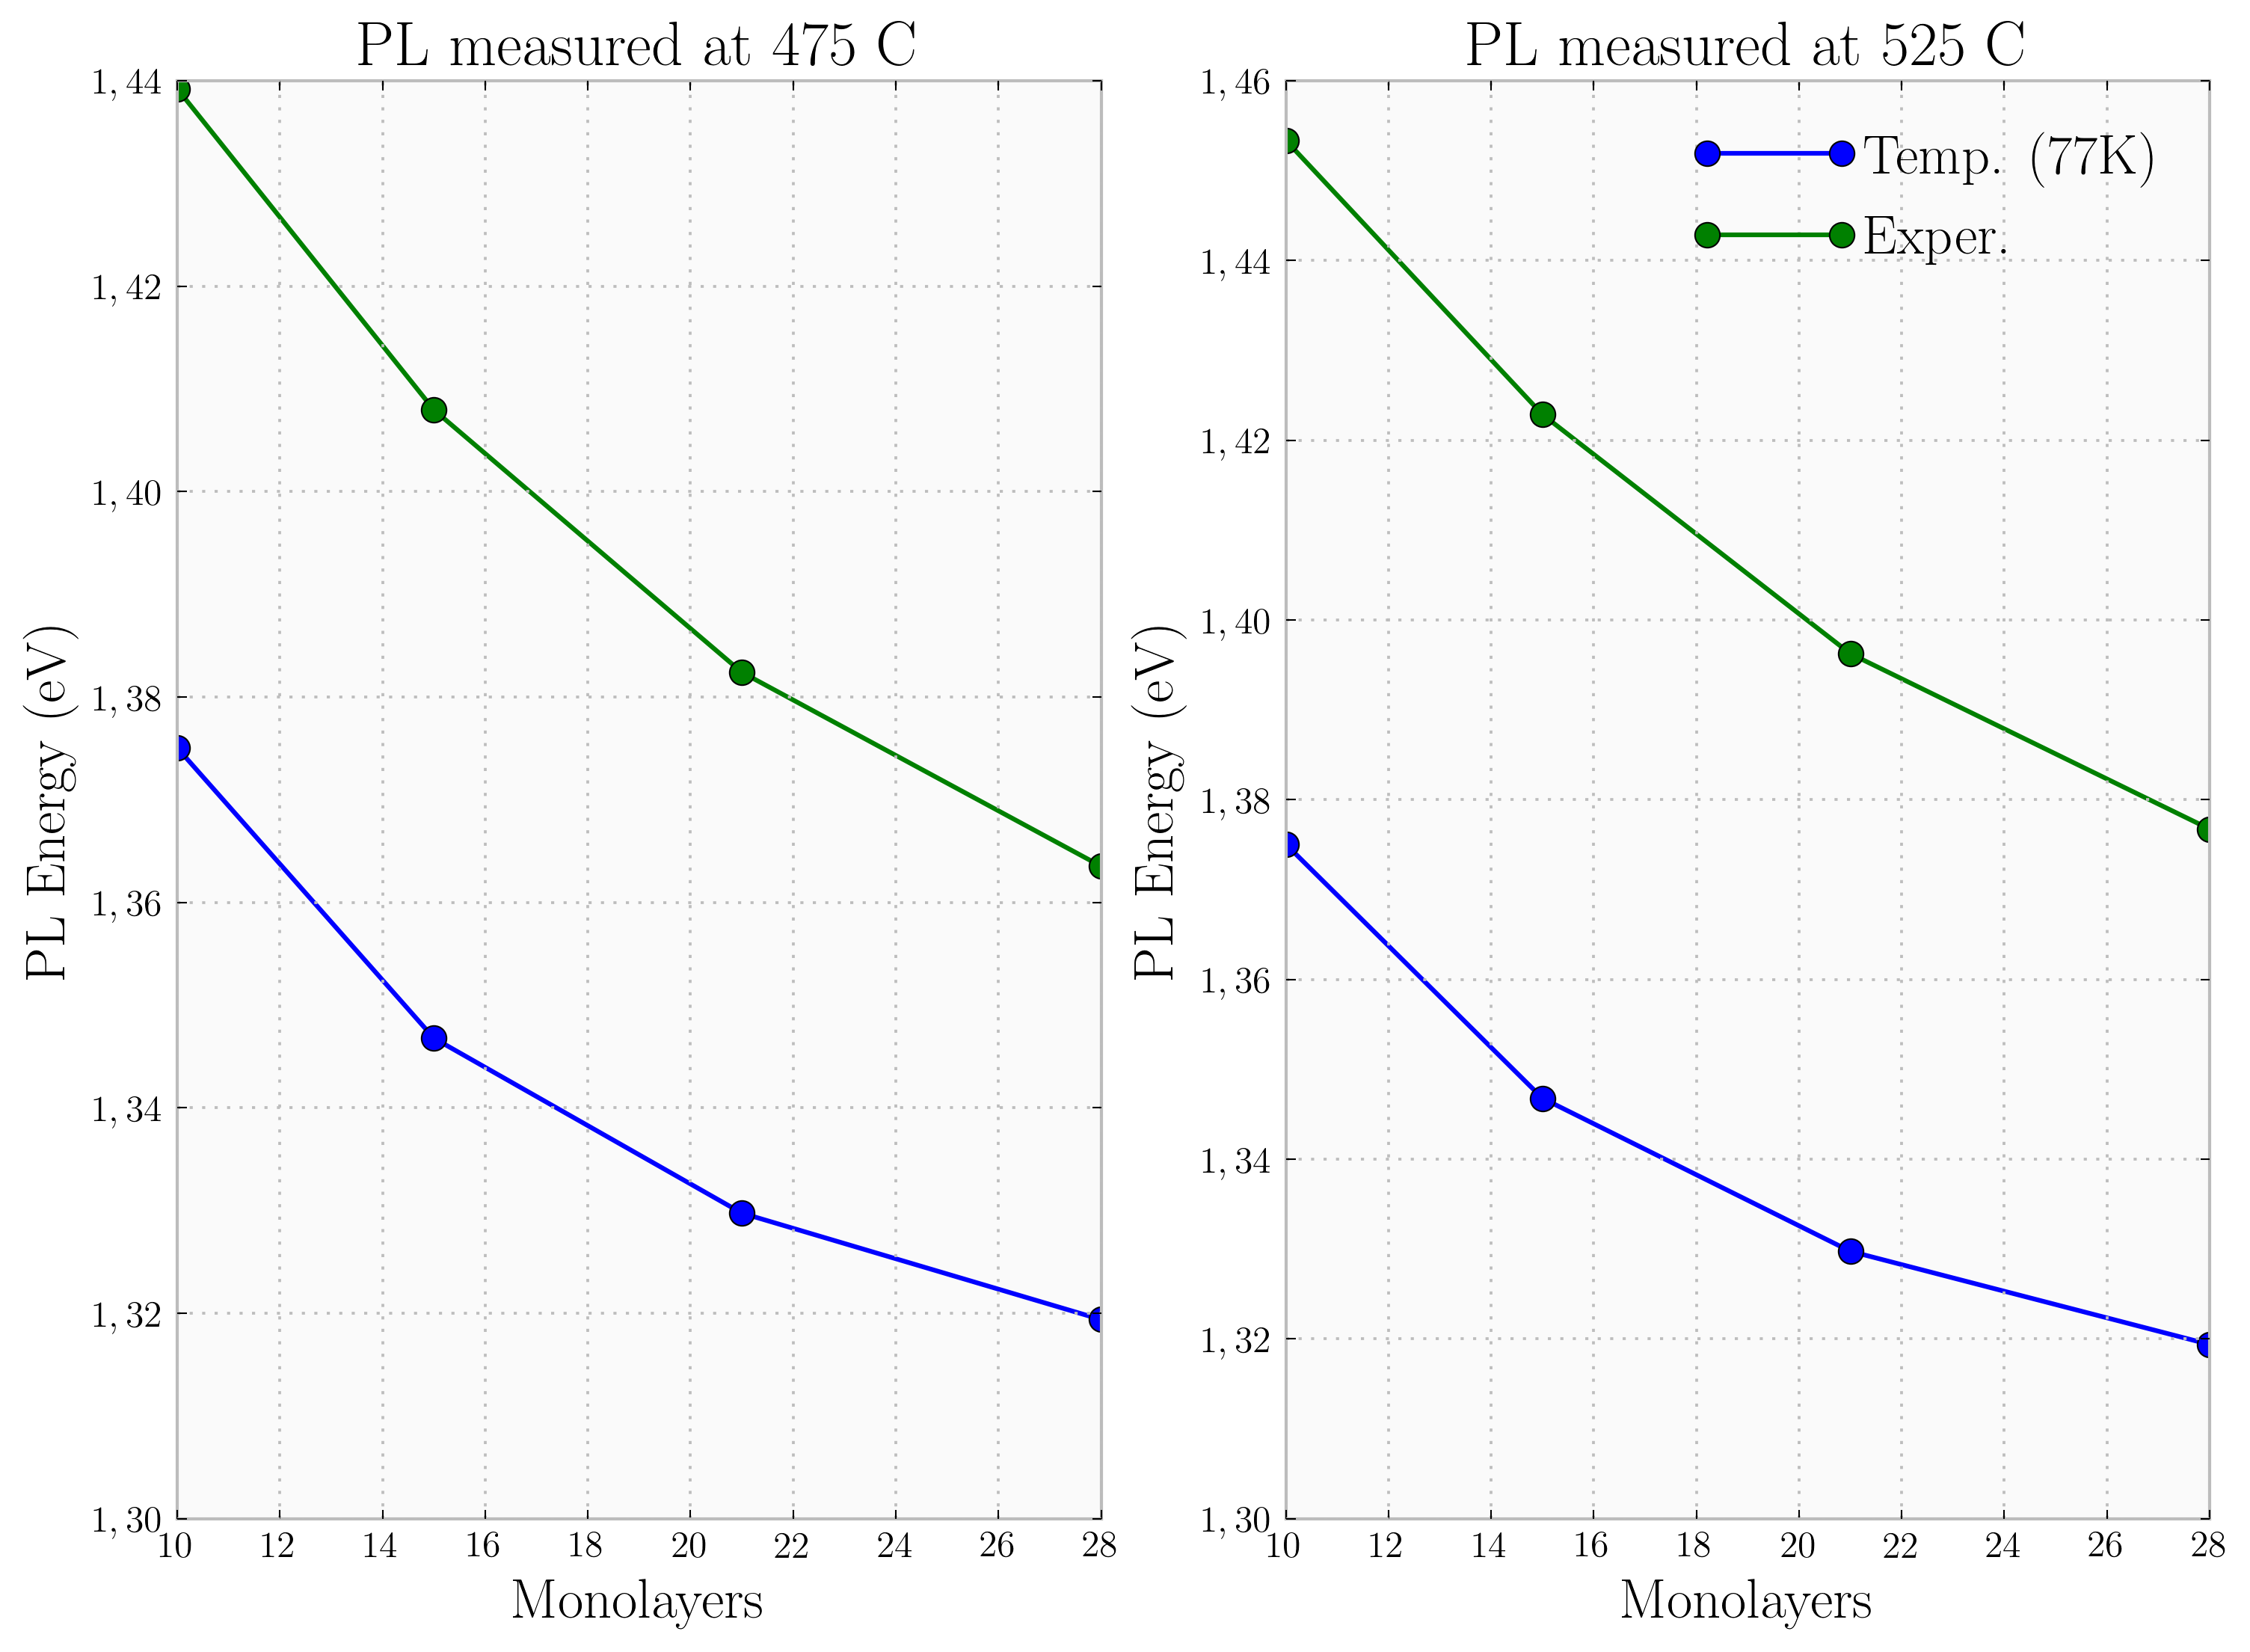

In [48]:
pl_gap77_475 = pl_numeric['temp_only'][475]
pl_gap77_525 = pl_numeric['temp_only'][525]

pl_experi_475 = samples[475]
pl_experi_525 = samples[525]

ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

temp475, = ax1.plot(ml_grid, pl_gap77_475, '-o')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
ax1.grid(True)
ax1.set_xlabel('Monolayers')
ax1.set_ylabel('PL Energy (eV)')
ax1.title.set_text('PL measured at 475 C')

temp525, = ax2.plot(ml_grid, pl_gap77_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers')
ax2.set_ylabel('PL Energy (eV)')
ax2.title.set_text('PL measured at 525 C')

plt.legend([temp475, exp475], ['Temp. (77K)','Exper.'], loc='best')
plt.plot()

## Efeitos da tensão

vamos incluir a tensão.

In [49]:
a    = np.vectorize(lambda x: -6.08 *x+(1-x)* -8.33 )
b    = np.vectorize(lambda x: -1.55 *x+(1-x)* -1.90 )
c11  = np.vectorize(lambda x:  0.83 *x+(1-x)*  1.22 )
c12  = np.vectorize(lambda x:  0.45 *x+(1-x)*  0.57 )

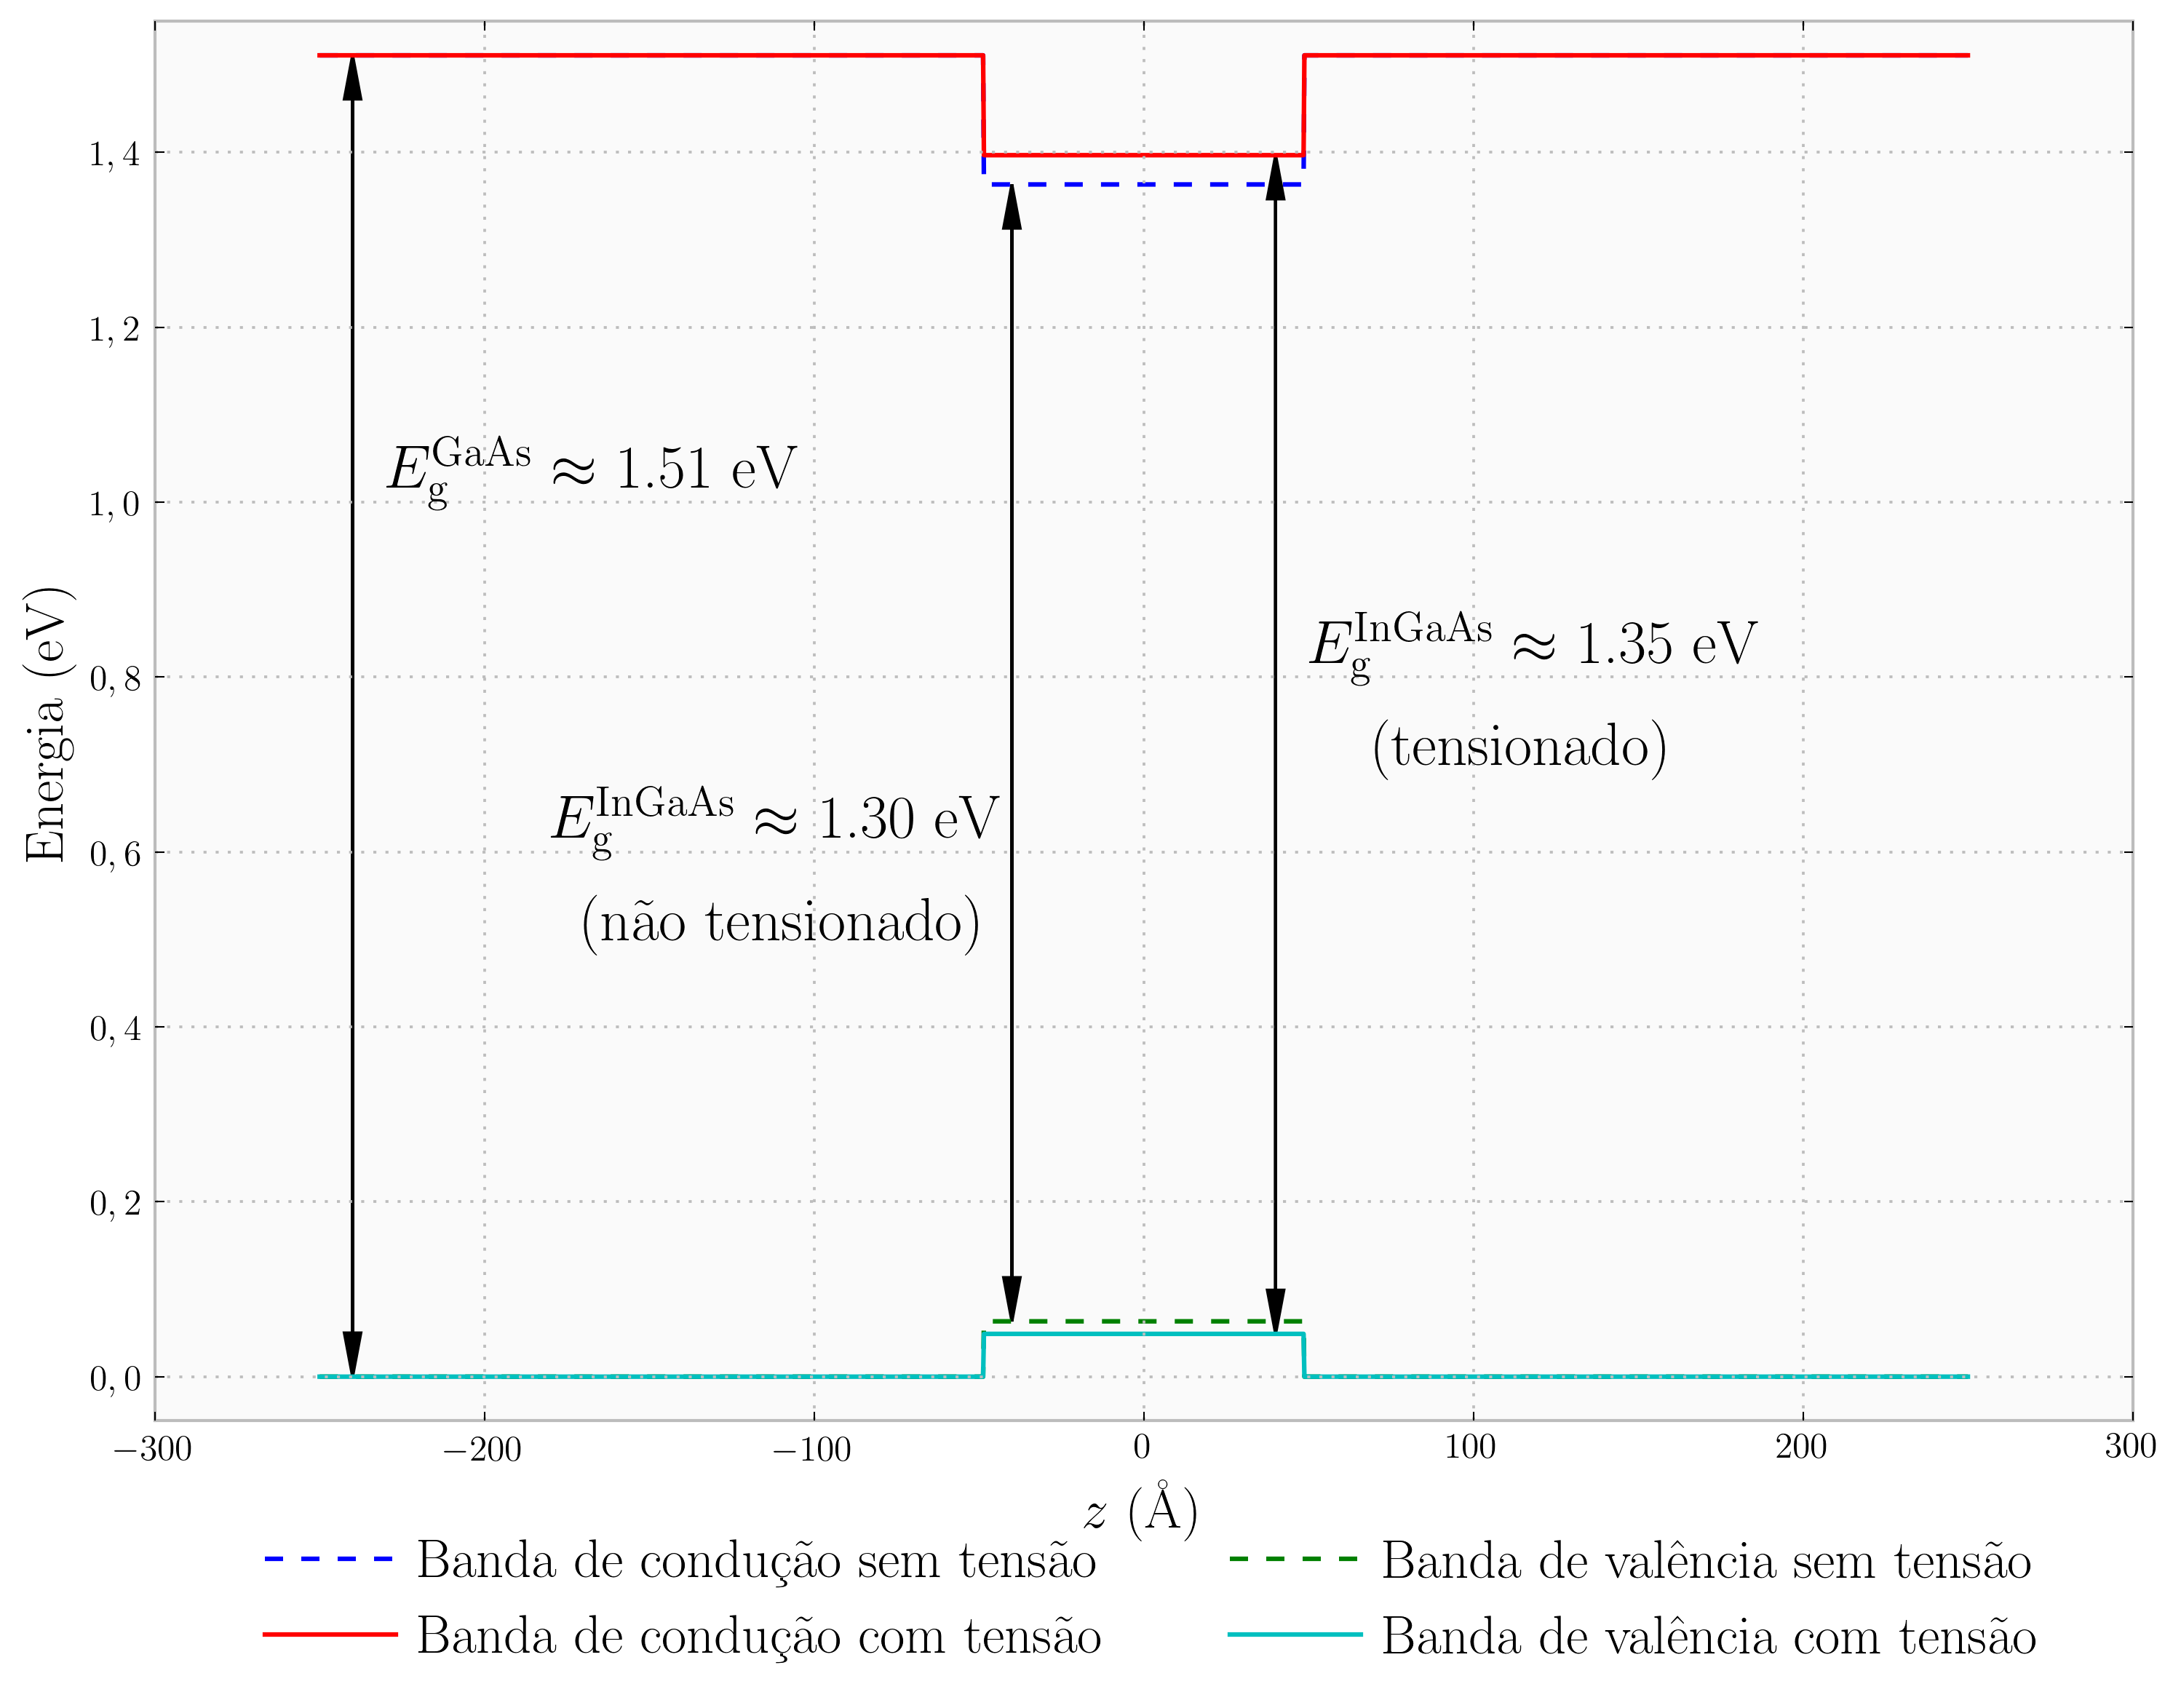

In [50]:
ml         = 21
T          = 525
R          = 0.867

x_well     = [x0] * ml #x_grid(ml, x0, R)
x_barrier  = [0.0] * int(250.0 / a0(0.0))

x_total    = x_barrier+x_well+x_barrier
sys_len    = np.sum([a0(x) for x in x_total])
z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
f1         = interp1d(z_temp, x_total, kind='nearest')
x_total    = f1(z_ang_in)

z_au_in    = z_ang_in / au2ang
me_in      = np.vectorize(me)(x_total)
mhh_in     = np.vectorize(mhh)(x_total)
v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])

Vc         = v_shape_in*CBO
Vv         = v_shape_in*VBO
Vc_red     = Vc-np.min(Vc)
Vv_red     = Vv-np.min(Vv)
Vc_au      = Vc_red / au2ev
Vv_au      = Vv_red / au2ev

_a   = a(x_total)
_b   = b(x_total)
_c11 = c11(x_total)
_c12 = c12(x_total)
a0_vec  = np.vectorize(a0)

_epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
v_shape_in_st = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11

Vc_st       = v_shape_in_st*CBO
Vv_st       = v_shape_in_st*VBO



#fig, (ax1, ax2) = plt.subplots(1,2)
fig, ax1 = plt.subplots(1,1)

leg_vc, = plt.plot(z_ang, Vc-np.max(Vc)+np.max(v_shape_in), '--')
leg_vv, = plt.plot(z_ang, -1*(Vv-np.max(Vv)), '--')

leg_vc_st, = plt.plot(z_ang, Vc_st-np.max(Vc_st)+np.max(v_shape_in), lw='1.5')
leg_vv_st, = plt.plot(z_ang, -1*(Vv_st-np.max(Vv_st)), lw='1.5')

ax1.grid(True)
ax1.set_xlabel(r'$z$ (\AA)')
ax1.set_ylabel('Energia (eV)')
#ax1.title.set_text(r'Perfil de potencial das bandas de val\^{e}ncia e condu\c{c}\~{a}o com e sem tens\~{a}o (77 K)')

maxv = np.max(v_shape_in)
maxss = np.min(Vc-np.max(Vc)+np.max(v_shape_in))
minss = np.max(-1*(Vv-np.max(Vv)))
maxcs = np.min(Vc_st-np.max(Vc_st)+np.max(v_shape_in))
mincs = np.max(-1*(Vv_st-np.max(Vv_st)))
hl=0.05

ax1.arrow(-240, 0, 0.0, maxv-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(-240, maxv, 0.0, -(maxv-hl), head_width=5, head_length=hl, fc='k', ec='k')

ax1.arrow(-40, minss, 0.0, (maxss-minss)-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(-40, maxss, 0.0, -(maxss-minss)+hl, head_width=5, head_length=hl, fc='k', ec='k')

ax1.arrow(40, mincs, 0.0, (maxcs-mincs)-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(40, maxcs, 0.0, -(maxcs-mincs)+hl, head_width=5, head_length=hl, fc='k', ec='k')

ax1.text(-230, 1.0, r'$E_\mathrm{g}^\mathrm{GaAs} \approx$ %.2f eV' % maxv)
ax1.text(-180, 0.6, r'$E_\mathrm{g}^\mathrm{InGaAs} \approx$ %.2f eV' % (maxss-minss))
ax1.text(-170, 0.5, r'(n\~{a}o tensionado)')
ax1.text(50, 0.8, r'$E_\mathrm{g}^\mathrm{InGaAs} \approx$ %.2f eV' % (maxcs-mincs))
ax1.text(70, 0.7, r'(tensionado)')
ax1.set_ylim([-0.05, 1.55])

plt.legend([leg_vc, leg_vc_st, leg_vv, leg_vv_st], [r'Banda de condu\c{c}\~{a}o sem tens\~{a}o',
                                                    r'Banda de condu\c{c}\~{a}o com tens\~{a}o',
                                                    r'Banda de val\^{e}ncia sem tens\~{a}o',
                                                    r'Banda de val\^{e}ncia com tens\~{a}o'],
          loc='upper center', bbox_to_anchor=(0.5, -0.05),  shadow=True, ncol=2)
plt.savefig('figuras/ingaas_tensao_77k.png', bbox_inches='tight')

In [51]:
# saving values for future comparison
pl_numeric['temp_strain'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = [x0] * ml #x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        
        _a   = a(x_total)
        _b   = b(x_total)
        _c11 = c11(x_total)
        _c12 = c12(x_total)
        a0_vec  = np.vectorize(a0)
        
        _epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
        v_shape_in = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['temp_strain'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4534, PL_num = 1.4139
T = 475 C, R = 0.7780, ML = 10, PL = 1.4392, PL_num = 1.4139
T = 525 C, R = 0.8670, ML = 15, PL = 1.4229, PL_num = 1.3903
T = 475 C, R = 0.7780, ML = 15, PL = 1.4080, PL_num = 1.3903
T = 525 C, R = 0.8670, ML = 21, PL = 1.3962, PL_num = 1.3754
T = 475 C, R = 0.7780, ML = 21, PL = 1.3824, PL_num = 1.3754
T = 525 C, R = 0.8670, ML = 28, PL = 1.3767, PL_num = 1.3660
T = 475 C, R = 0.7780, ML = 28, PL = 1.3635, PL_num = 1.3660


[]

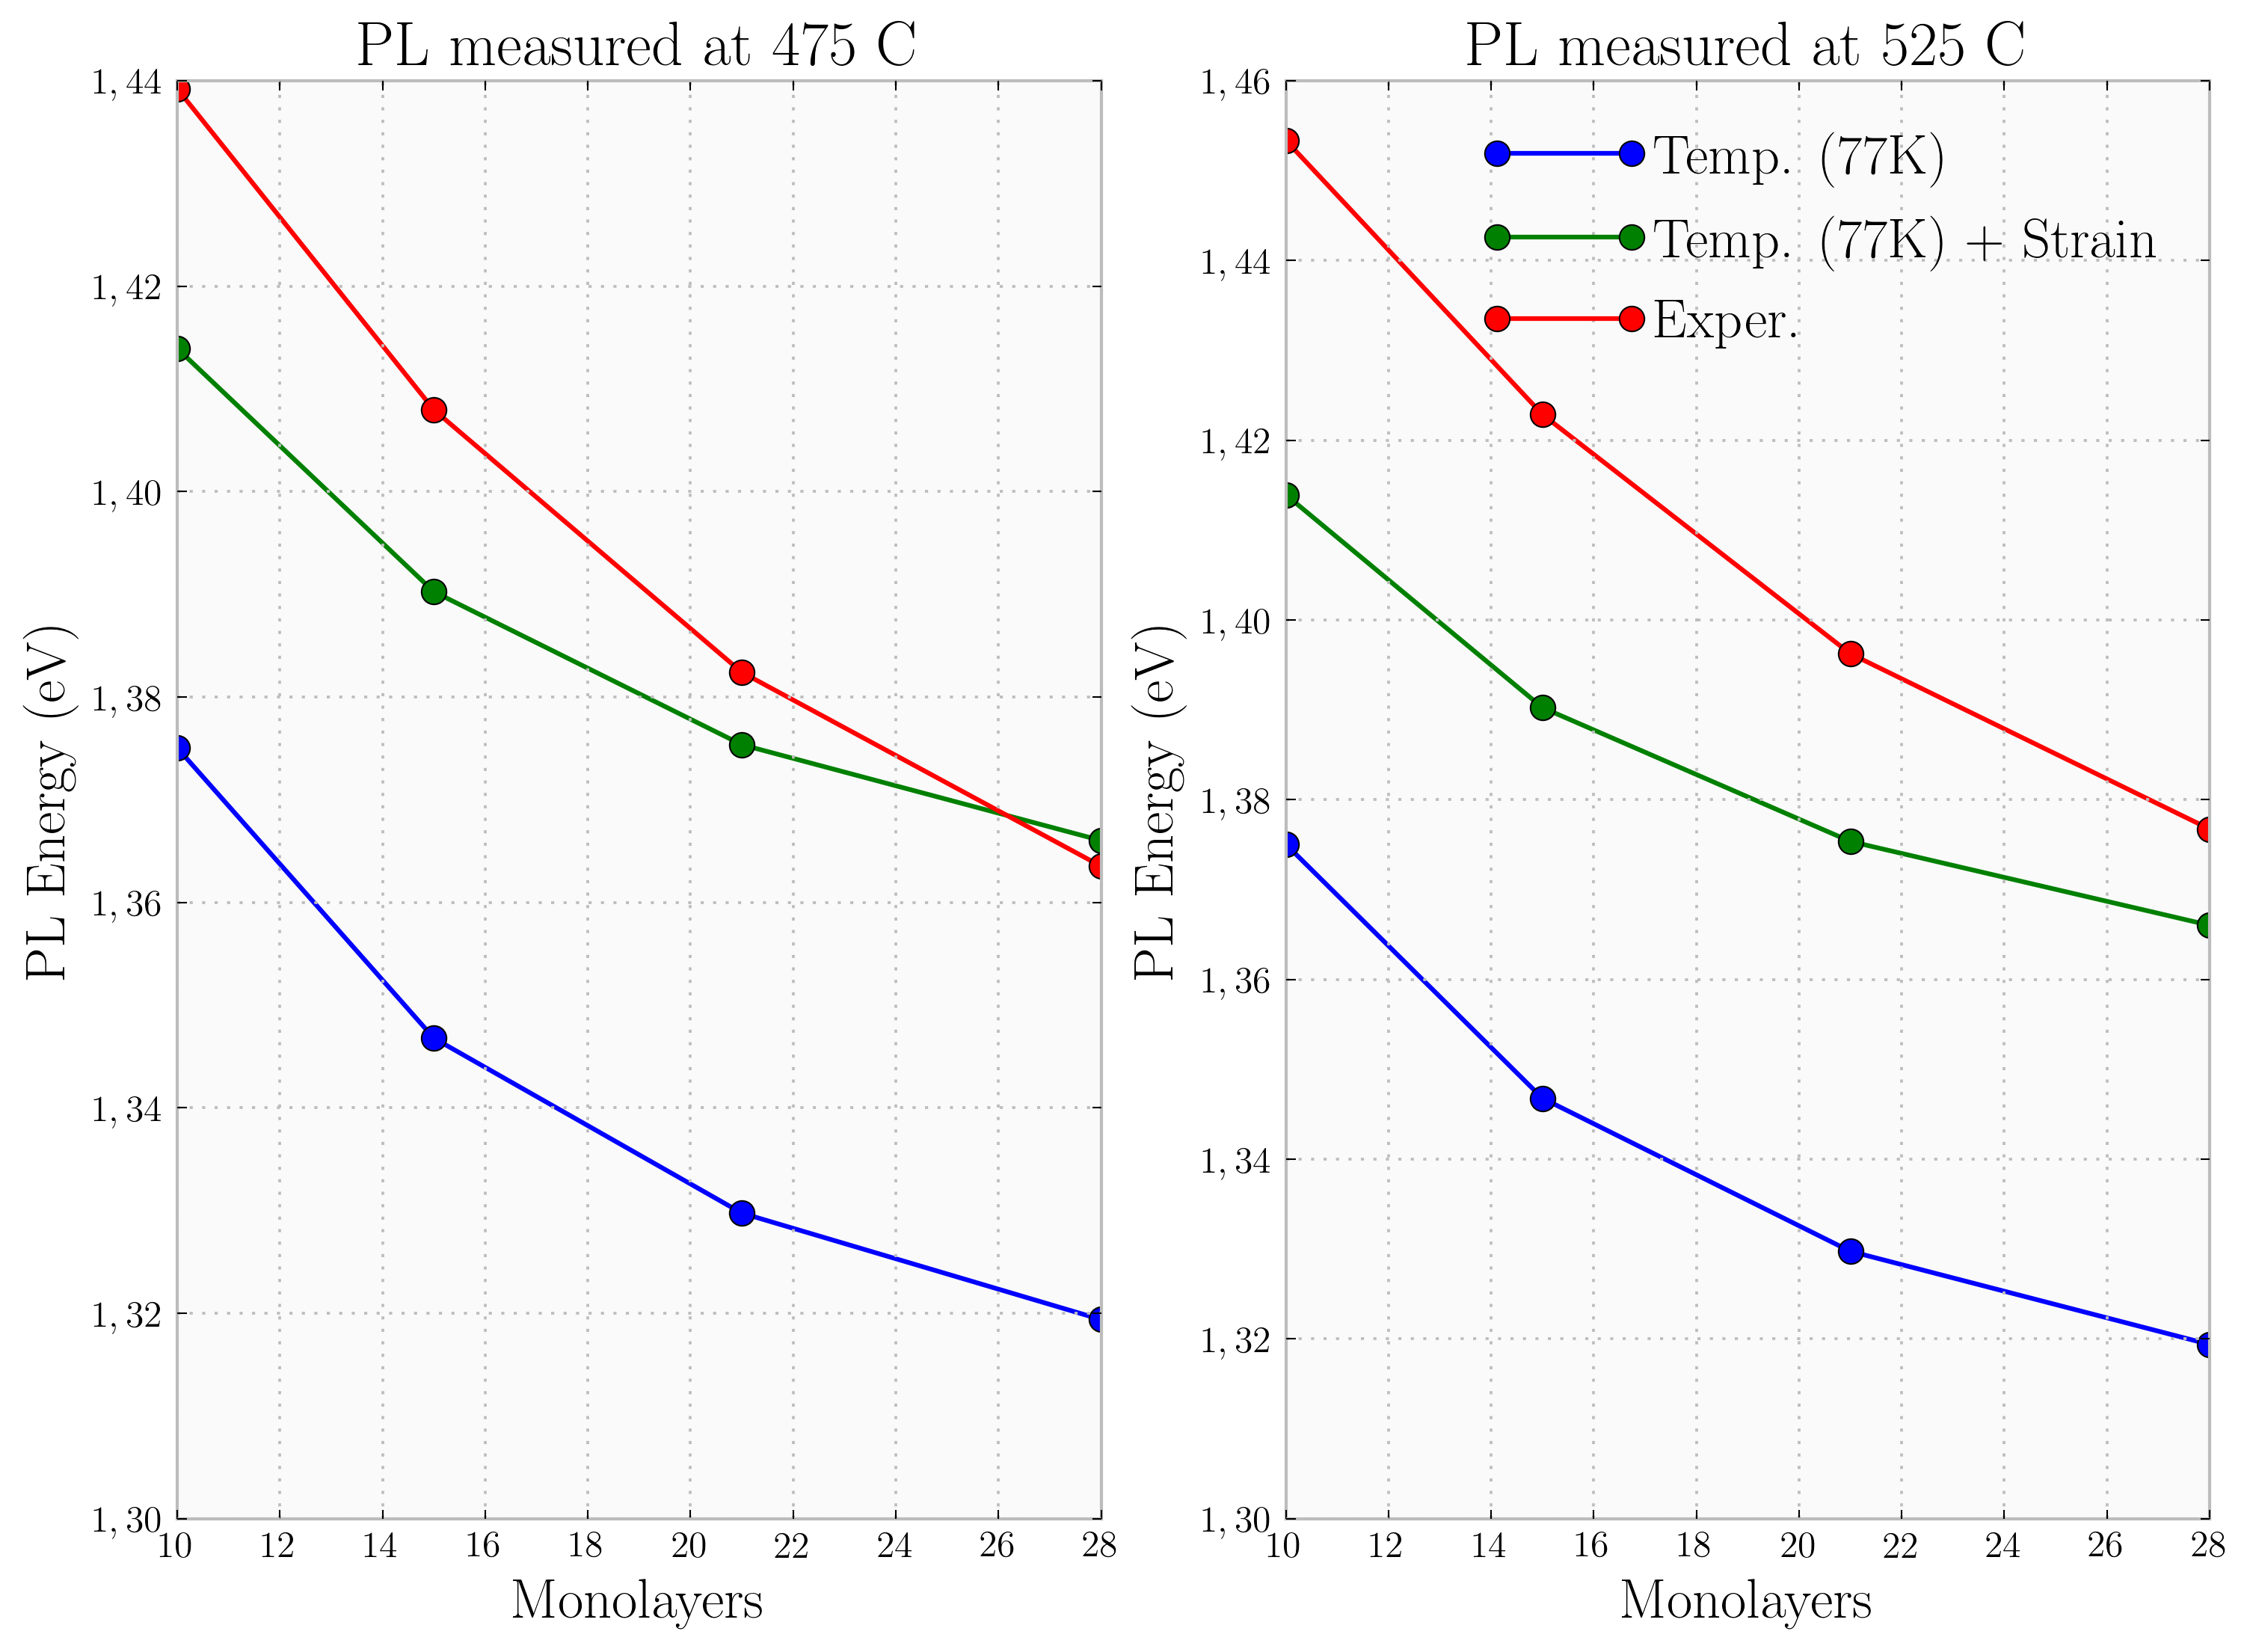

In [52]:
pl_gap77_475 = pl_numeric['temp_only'][475]
pl_gap77_525 = pl_numeric['temp_only'][525]

pl_stress_475 = pl_numeric['temp_strain'][475]
pl_stress_525 = pl_numeric['temp_strain'][525]

pl_experi_475 = samples[475]
pl_experi_525 = samples[525]

ml_grid       = samples['ml']

fig, (ax1, ax2) = plt.subplots(1,2)

temp475, = ax1.plot(ml_grid, pl_gap77_475, '-o')
strain475, = ax1.plot(ml_grid, pl_stress_475, '-o')
exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
ax1.grid(True)
ax1.set_xlabel('Monolayers')
ax1.set_ylabel('PL Energy (eV)')
ax1.title.set_text('PL measured at 475 C')

temp525, = ax2.plot(ml_grid, pl_gap77_525, '-o')
strain525, = ax2.plot(ml_grid, pl_stress_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers')
ax2.set_ylabel('PL Energy (eV)')
ax2.title.set_text('PL measured at 525 C')

plt.legend([temp475, strain475, exp475], ['Temp. (77K)', 'Temp. (77K) + Strain', 'Exper.'], loc='best')
plt.plot()

## Levando em conta a segregação

Vamos começar a melhorar nosso modelo incluindo a segregação.

In [53]:
def in_segregation(x0, R, n, N=None):
    """
    return the actual indium concentration in the nth layer

    Params
    ------
    x0 : float
        the indium concentration between 0 and 1
    R : float
        the segregation coefficient
    n : int
        the current layer
    N : int
        number of layers in the well
    """
    if N:
        return x0*(1-R**N)*R**(n-N)
    return x0*(1-R**n)

O poço será construído para cada número de monolayers e envolvido em $250$ Å de cada lado.

In [54]:
def x_grid(ml, x0, R):
    """
    for a given number of intendend monolayers inside the well
    return the indium concentration in each layer plus some
    layers that will have indium in the barrier
    """
    i = 0
    x_grid = []
    while True:
        i += 1
        if i > ml:
            in_x = in_segregation(x0, R, i, ml)
        else:
            in_x = in_segregation(x0, R, i)

        if in_x < 0.0001:
            break
        x_grid.append(in_x)
    return x_grid

Exemplo, para 10 monolayers, $x=0.14$ e $R=0.9$:        

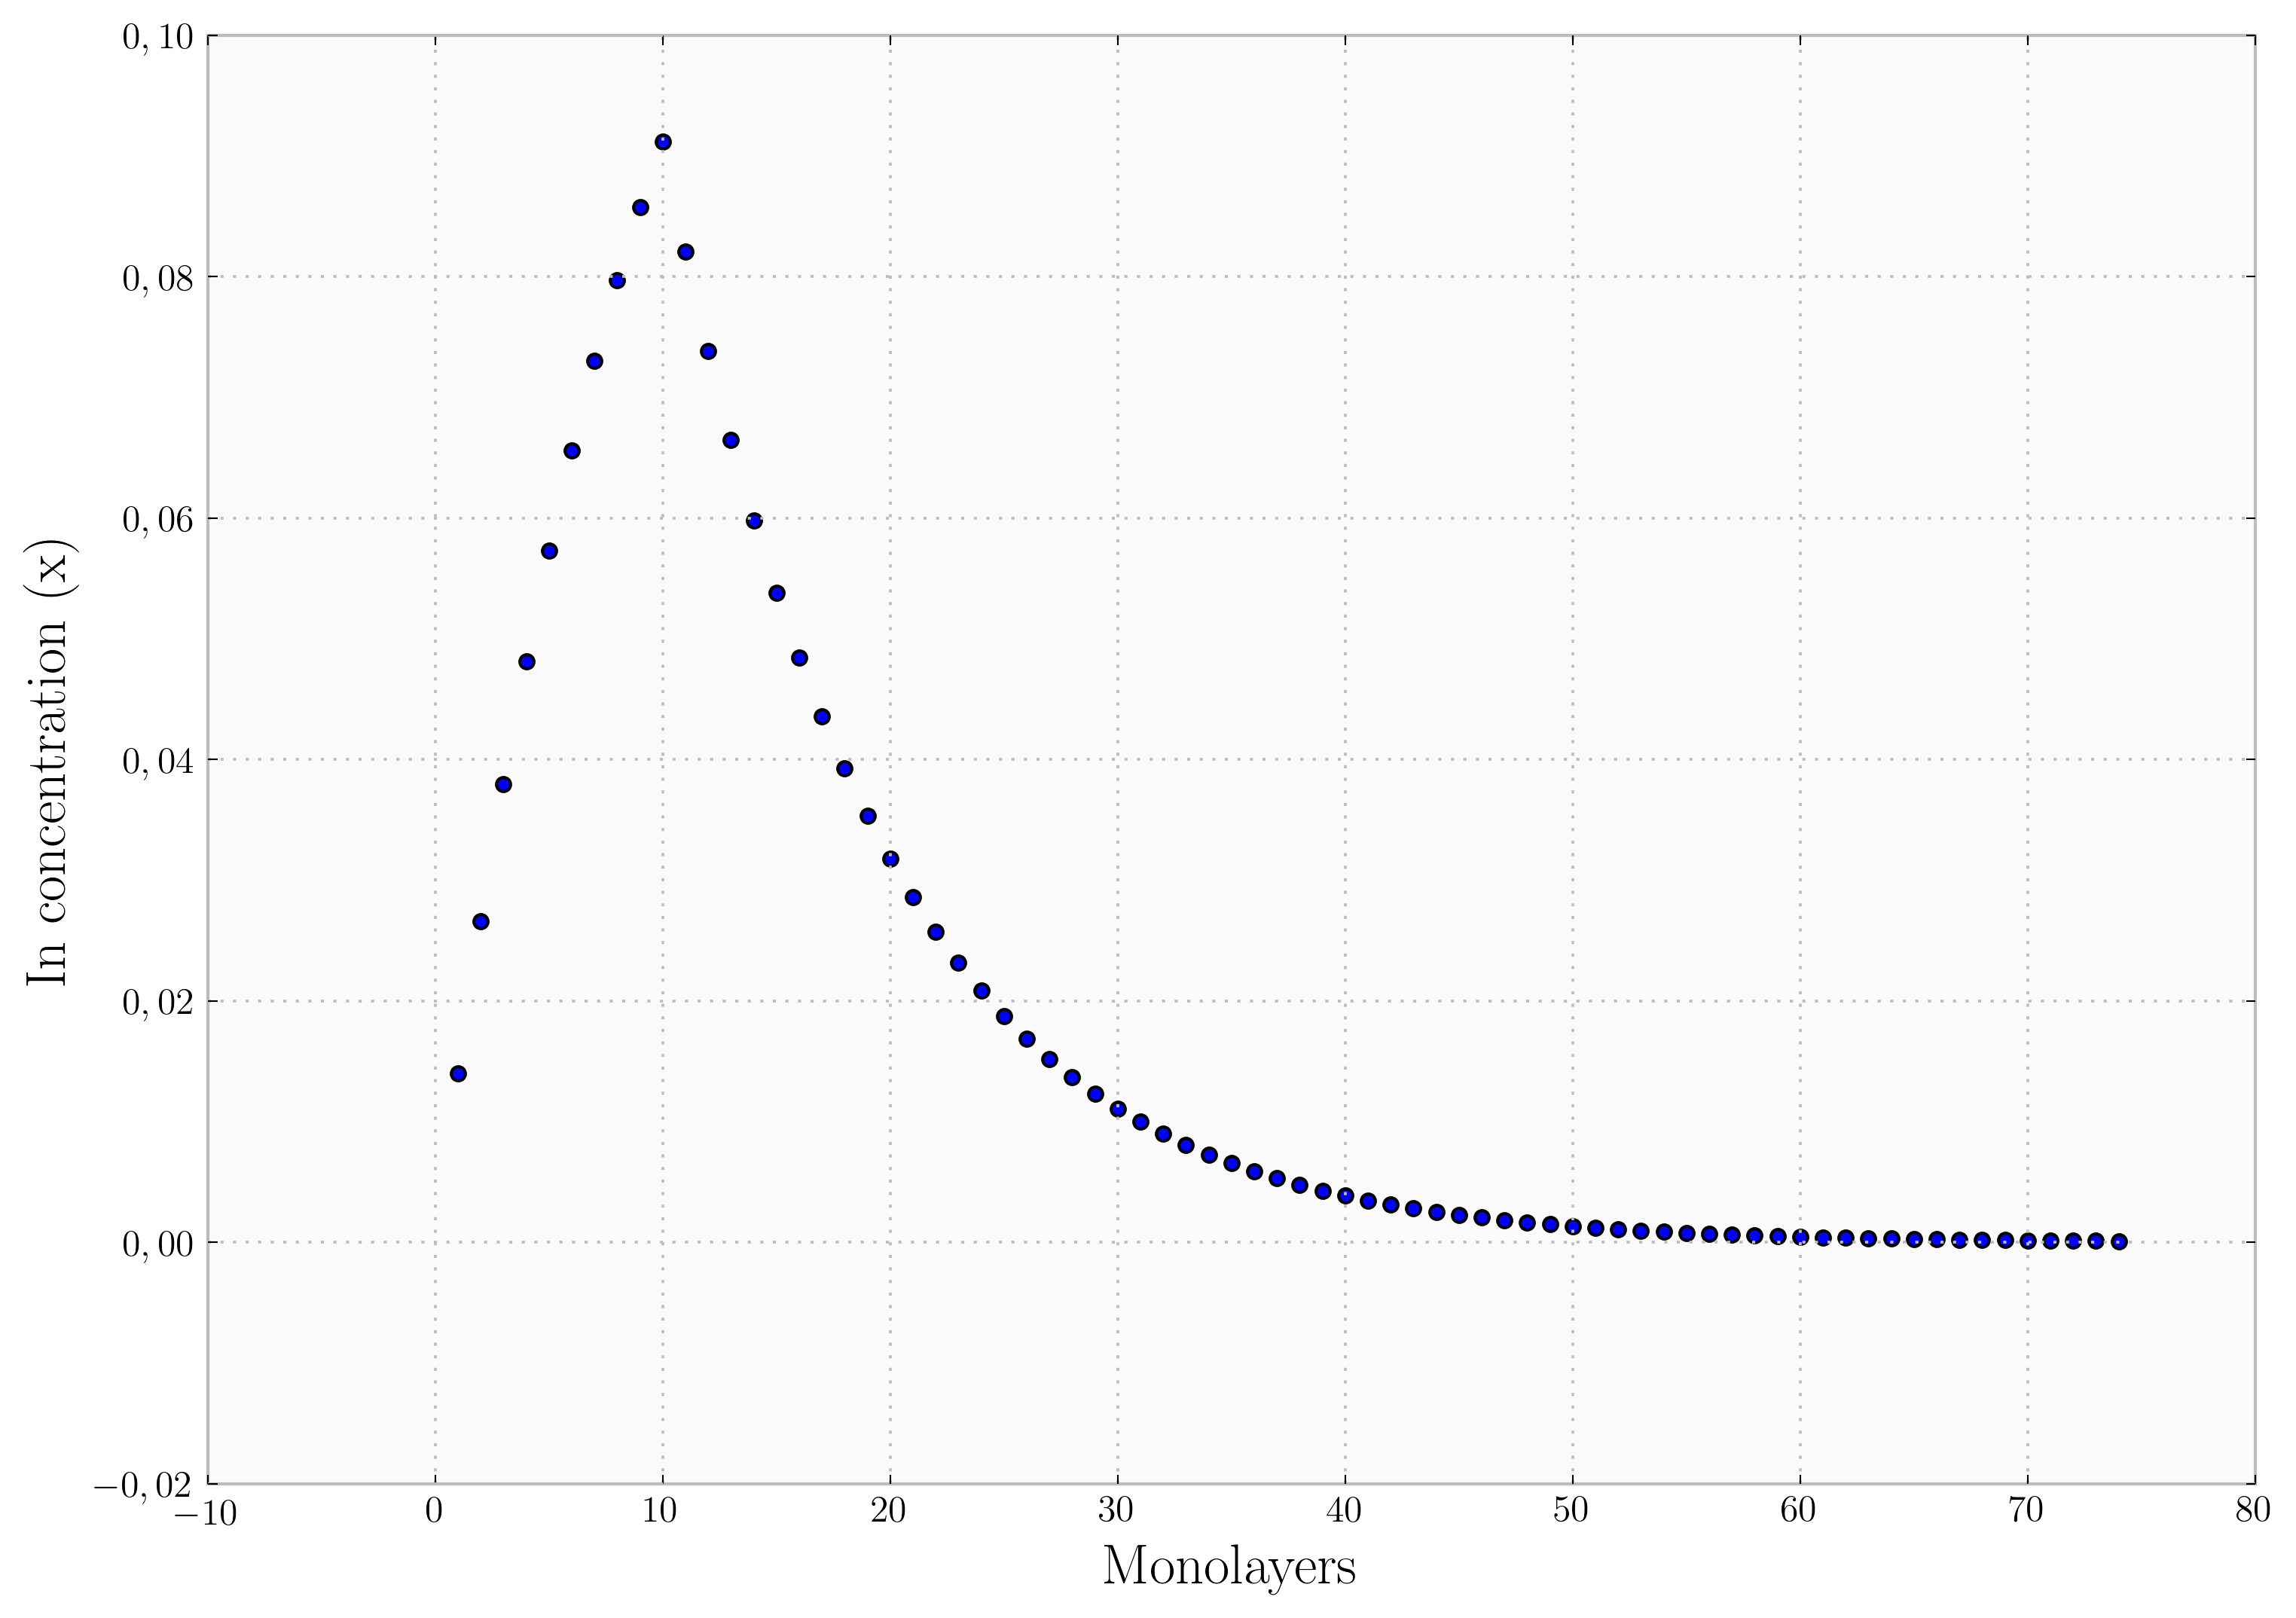

In [55]:
example_x_grid = x_grid(10, 0.14, 0.9)
fig, ax = plt.subplots()
ax.scatter(range(len(example_x_grid)+1)[1:], example_x_grid)
ax.grid(True)
ax.set_xlabel('Monolayers')
ax.set_ylabel('In concentration (x)')
plt.show()

Então nós conseguimos calcular a concentração em cada monolayer. Vamos agora gerar um grid de coordenadas z tal que o poço como o da figura acima ainda tenha $250$ Å de cada lado.

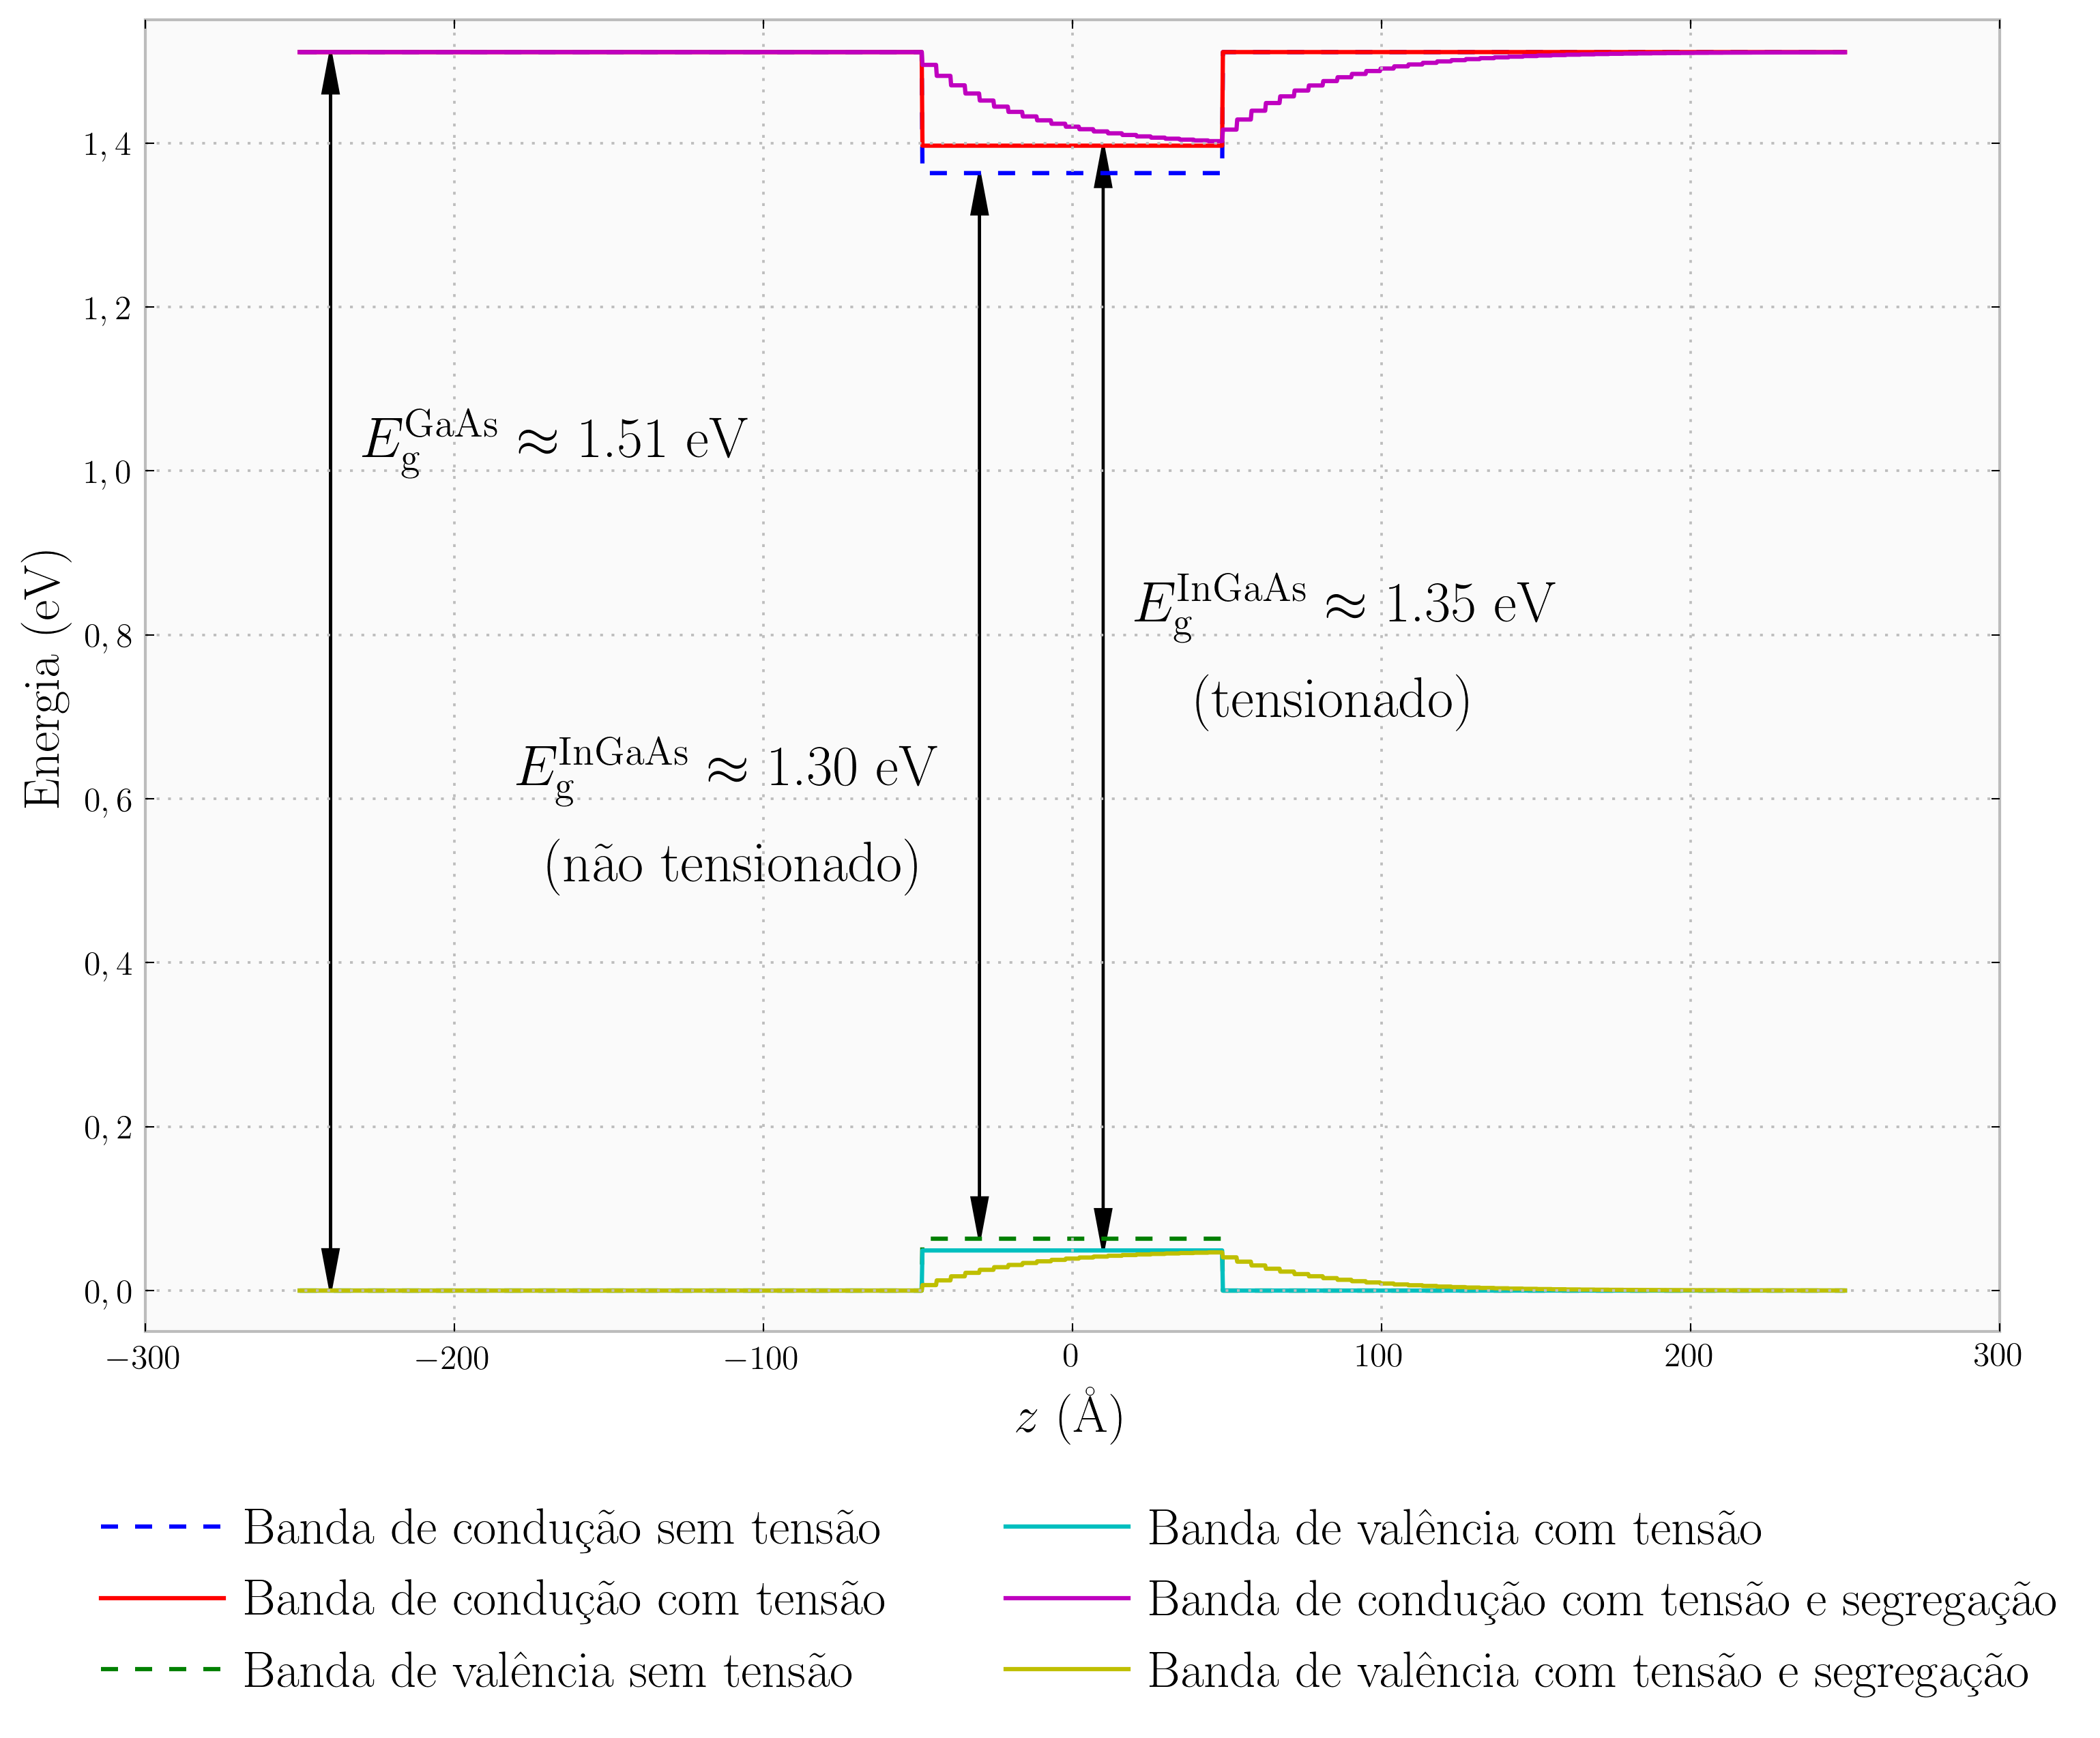

In [56]:
ml         = 21
T          = 525
R          = 0.867

x_well     = [x0] * ml #x_grid(ml, x0, R)
x_barrier  = [0.0] * int(250.0 / a0(0.0))

x_total    = x_barrier+x_well+x_barrier
sys_len    = np.sum([a0(x) for x in x_total])
z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
f1         = interp1d(z_temp, x_total, kind='nearest')
x_total    = f1(z_ang_in)

z_au_in    = z_ang_in / au2ang
me_in      = np.vectorize(me)(x_total)
mhh_in     = np.vectorize(mhh)(x_total)
v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])

Vc         = v_shape_in*CBO
Vv         = v_shape_in*VBO
Vc_red     = Vc-np.min(Vc)
Vv_red     = Vv-np.min(Vv)
Vc_au      = Vc_red / au2ev
Vv_au      = Vv_red / au2ev

_a   = a(x_total)
_b   = b(x_total)
_c11 = c11(x_total)
_c12 = c12(x_total)
a0_vec  = np.vectorize(a0)

_epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
v_shape_in_st = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11

Vc_st       = v_shape_in_st*CBO
Vv_st       = v_shape_in_st*VBO




x_well     = x_grid(ml, x0, R)
x_bulk  = [0.0] * int(250.0 / a0(0.0))
x_total    = x_bulk+x_well[:-6]#+x_barrier

sys_len    = np.sum([a0(x) for x in x_total])
z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
f1         = interp1d(z_temp, x_total, kind='nearest')
x_total    = f1(z_ang_in)

z_au_in    = z_ang_in / au2ang
me_in      = np.vectorize(me)(x_total)
mhh_in     = np.vectorize(mhh)(x_total)
v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])

_a   = a(x_total)
_b   = b(x_total)
_c11 = c11(x_total)
_c12 = c12(x_total)
a0_vec  = np.vectorize(a0)

_epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
v_shape_in = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11

Vc_seg         = v_shape_in*CBO
Vv_seg         = v_shape_in*VBO

#fig, (ax1, ax2) = plt.subplots(1,2)
fig, ax1 = plt.subplots(1,1)

leg_vc, = plt.plot(z_ang, Vc-np.max(Vc)+np.max(v_shape_in), '--')
leg_vv, = plt.plot(z_ang, -1*(Vv-np.max(Vv)), '--')

leg_vc_st, = plt.plot(z_ang, Vc_st-np.max(Vc_st)+np.max(v_shape_in), lw='1.5')
leg_vv_st, = plt.plot(z_ang, -1*(Vv_st-np.max(Vv_st)), lw='1.5')

leg_vc_seg, = plt.plot(z_ang, Vc_seg-np.max(Vc_seg)+np.max(v_shape_in), lw='1.5')
leg_vv_seg, = plt.plot(z_ang, -1*(Vv_seg-np.max(Vv_seg)), lw='1.5')

ax1.grid(True)
ax1.set_xlabel(r'$z$ (\AA)')
ax1.set_ylabel('Energia (eV)')
#ax1.title.set_text(r'Perfil de potencial com tens\~{a}o e segrega\c{c}\~{a}o (77 K)')

maxv = np.max(v_shape_in)
maxss = np.min(Vc-np.max(Vc)+np.max(v_shape_in))
minss = np.max(-1*(Vv-np.max(Vv)))
maxcs = np.min(Vc_st-np.max(Vc_st)+np.max(v_shape_in))
mincs = np.max(-1*(Vv_st-np.max(Vv_st)))
hl=0.05

ax1.arrow(-240, 0, 0.0, maxv-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(-240, maxv, 0.0, -(maxv-hl), head_width=5, head_length=hl, fc='k', ec='k')

ax1.arrow(-30, minss, 0.0, (maxss-minss)-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(-30, maxss, 0.0, -(maxss-minss)+hl, head_width=5, head_length=hl, fc='k', ec='k')

ax1.arrow(10, mincs, 0.0, (maxcs-mincs)-hl, head_width=5, head_length=hl, fc='k', ec='k')
ax1.arrow(10, maxcs, 0.0, -(maxcs-mincs)+hl, head_width=5, head_length=hl, fc='k', ec='k')

ax1.text(-230, 1.0, r'$E_\mathrm{g}^\mathrm{GaAs} \approx$ %.2f eV' % maxv)
ax1.text(-180, 0.6, r'$E_\mathrm{g}^\mathrm{InGaAs} \approx$ %.2f eV' % (maxss-minss))
ax1.text(-170, 0.5, r'(n\~{a}o tensionado)')
ax1.text(20, 0.8, r'$E_\mathrm{g}^\mathrm{InGaAs} \approx$ %.2f eV' % (maxcs-mincs))
ax1.text(40, 0.7, r'(tensionado)')
ax1.set_ylim([-0.05, 1.55])


plt.legend([leg_vc, leg_vc_st, leg_vv, leg_vv_st, leg_vc_seg, leg_vv_seg], 
           [r'Banda de condu\c{c}\~{a}o sem tens\~{a}o',
            r'Banda de condu\c{c}\~{a}o com tens\~{a}o',
            r'Banda de val\^{e}ncia sem tens\~{a}o',
            r'Banda de val\^{e}ncia com tens\~{a}o',
            r'Banda de condu\c{c}\~{a}o com tens\~{a}o e segrega\c{c}\~{a}o',
            r'Banda de val\^{e}ncia com tens\~{a}o e segrega\c{c}\~{a}o'],
          loc='upper center', bbox_to_anchor=(0.5, -0.10),  shadow=True, ncol=2)
#plt.plot()
plt.savefig('figuras/ingaas_tensao_segregacao_77.png', bbox_inches='tight')

In [57]:
# saving values for future comparison
pl_numeric['segregation_temp_strain'] = sample_skeleton()
for i, ml in enumerate(samples['ml']):
    for T, R in R_T.items():
        x_well     = x_grid(ml, x0, R)
        x_barrier  = [0.0] * int(250.0 / a0(0.0))
        
        x_total    = x_barrier+x_well+x_barrier
        sys_len    = np.sum([a0(x) for x in x_total])
        z_temp     = np.linspace(-sys_len/2,sys_len/2,len(x_total))
        z_ang_in   = np.linspace(-sys_len/2,sys_len/2,N)
        f1         = interp1d(z_temp, x_total, kind='nearest')
        x_total    = f1(z_ang_in)
        
        z_au_in    = z_ang_in / au2ang
        me_in      = np.vectorize(me)(x_total)
        mhh_in     = np.vectorize(mhh)(x_total)
        v_shape_in = np.vectorize(eg_xt_ingaas)(x_total, len(x_total)*[77])
        
        _a   = a(x_total)
        _b   = b(x_total)
        _c11 = c11(x_total)
        _c12 = c12(x_total)
        a0_vec  = np.vectorize(a0)
        
        _epp = (a0_vec([0])[0]-a0_vec(x_total))/a0_vec(x_total)
        v_shape_in = v_shape_in + (2*_a*(_c11-_c12)-_b*(_c11+2*_c12))*_epp/_c11
        
        Vc         = v_shape_in*CBO
        Vv         = v_shape_in*VBO
        Vc_red     = Vc-np.min(Vc)
        Vv_red     = Vv-np.min(Vv)
        Vc_au      = Vc_red / au2ev
        Vv_au      = Vv_red / au2ev

        GAP        = np.min(Vc+Vv)
        res_e      = fundamental(z_au_in, Vc_au, me_in)
        eigen_e    = res_e['eigenvalue'] * au2ev # in eV
        res_hh     = fundamental(z_au_in, Vv_au, mhh_in)
        eigen_hh   = res_hh['eigenvalue'] * au2ev # in eV

        PL = GAP + eigen_e + eigen_hh
    
        pl_numeric['segregation_temp_strain'][T][i] = PL
        print("T = %d C, R = %.4f, ML = %d, PL = %.4f, PL_num = %.4f" % (T, R, ml, samples[T][i], PL))

T = 525 C, R = 0.8670, ML = 10, PL = 1.4534, PL_num = 1.4475
T = 475 C, R = 0.7780, ML = 10, PL = 1.4392, PL_num = 1.4331
T = 525 C, R = 0.8670, ML = 15, PL = 1.4229, PL_num = 1.4199
T = 475 C, R = 0.7780, ML = 15, PL = 1.4080, PL_num = 1.4050
T = 525 C, R = 0.8670, ML = 21, PL = 1.3962, PL_num = 1.3974
T = 475 C, R = 0.7780, ML = 21, PL = 1.3824, PL_num = 1.3850
T = 525 C, R = 0.8670, ML = 28, PL = 1.3767, PL_num = 1.3809
T = 475 C, R = 0.7780, ML = 28, PL = 1.3635, PL_num = 1.3719


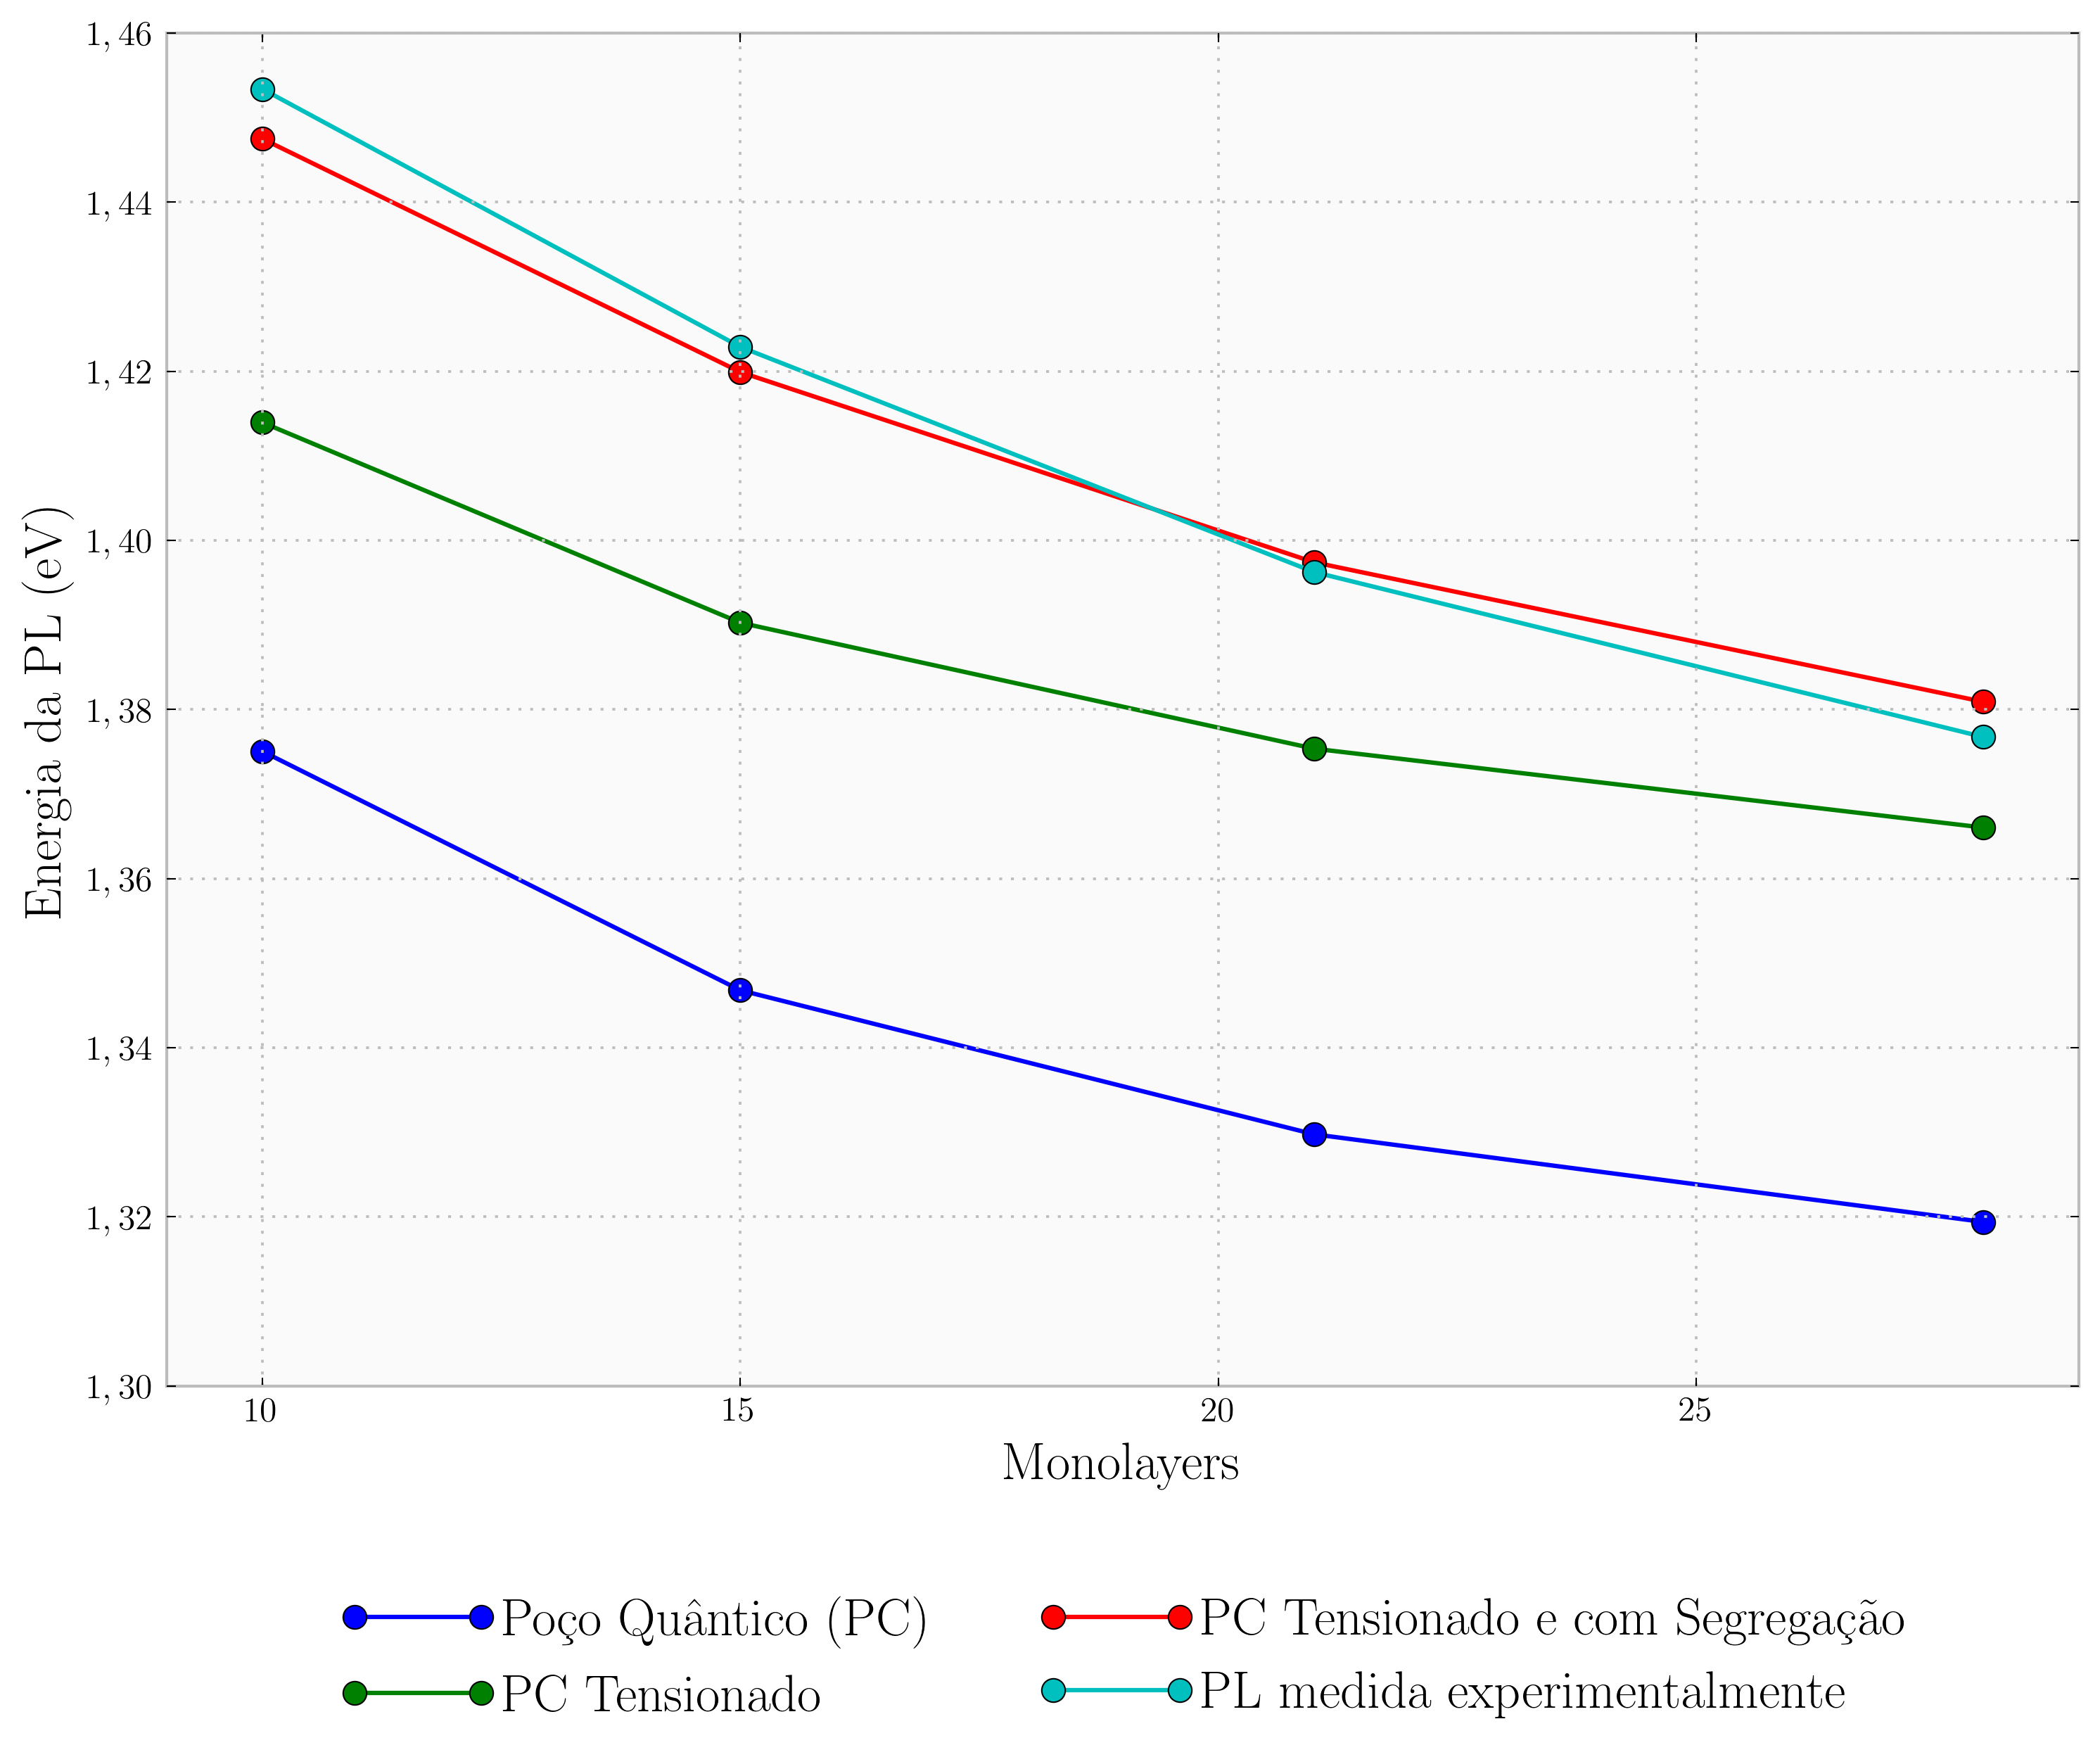

In [58]:
pl_gap77_475 = pl_numeric['temp_only'][475]
pl_gap77_525 = pl_numeric['temp_only'][525]

pl_stress_475 = pl_numeric['temp_strain'][475]
pl_stress_525 = pl_numeric['temp_strain'][525]

pl_stress_segreg_475 = pl_numeric['segregation_temp_strain'][475]
pl_stress_segreg_525 = pl_numeric['segregation_temp_strain'][525]

pl_experi_475 = samples[475]
pl_experi_525 = samples[525]

ml_grid       = samples['ml']

#fig, (ax1, ax2) = plt.subplots(1,2)
fig, (ax2) = plt.subplots(1,1)

# temp475, = ax1.plot(ml_grid, pl_gap77_475, '-o')
# strain475, = ax1.plot(ml_grid, pl_stress_475, '-o')
# strainsegreg475, = ax1.plot(ml_grid, pl_stress_segreg_475, '-o')
# exp475, = ax1.plot(ml_grid, pl_experi_475, '-o')
# ax1.grid(True)
# ax1.set_xlabel('Monolayers')
# ax1.set_ylabel('PL Energy (eV)')
# ax1.title.set_text(r'Sample grown at 475 $^\circ$C')

temp525, = ax2.plot(ml_grid, pl_gap77_525, '-o')
strain525, = ax2.plot(ml_grid, pl_stress_525, '-o')
strainsegreg525, = ax2.plot(ml_grid, pl_stress_segreg_525, '-o')
exp525, = ax2.plot(ml_grid, pl_experi_525, '-o')
ax2.grid(True)
ax2.set_xlabel('Monolayers')
ax2.set_ylabel('Energia da PL (eV)')
ax2.set_xlim([9, 29])
#ax2.title.set_text(r'Sample grown at 525 $^\circ$C')

#plt.legend([temp475, strain475, strainsegreg525, exp475], ['Quantum Well (QW)', 'Strained QW', 'Strained QW with Segregation', 'PL measured (Experiment)'],
plt.legend([temp525, strain525, strainsegreg525, exp525], [r'Po\c{c}o Qu\^{a}ntico (PC)', r'PC Tensionado', r'PC Tensionado e com Segrega\c{c}\~{a}o', 'PL medida experimentalmente'],
          loc='upper center', bbox_to_anchor=(0.50, -0.12),  shadow=True, ncol=2)
#plt.plot()
plt.savefig('figuras/ingaas_pl_77.png', bbox_inches='tight')